# DATASCI 347: Machine Learning (Fall 2025)
## Instructor: Alexander Williams Tolbert

# Clustering Analysis

## Introduction

### Outline
**Source:** Study this lecture, Read Chapter 10.3

**Case study:** group subjects via large dimensional mRNA sequences!

**Clustering Methods:** K-means, Hierarchical clustering (Read 10.3.2)

**K-means:**
- Group observations
- Close within groups and far away between groups
- Usual distance in p-dimensional space
- What to do with the groups found?

**Spectrum Analysis:**
- PCA first (or SVD first)
- Clustering

**Python-magic:**
- First experience with LARGE data
- `pd.read_csv()`, `to_csv()`: power of pandas
- `pickle.dump/load`: save your results
- heat map
- `KMeans()`
- `PCA()`
- `svd()` through `TruncatedSVD()`

This is an exciting lecture where you see one may have significant discoveries when done right analyses.

In [7]:
# Import necessary libraries for data analysis and clustering
import pandas as pd  # For handling data tables like spreadsheets
import numpy as np   # For mathematical operations on arrays of numbers
import matplotlib.pyplot as plt  # For creating graphs and plots
import seaborn as sns  # For advanced data visualization
from sklearn.cluster import KMeans  # Machine learning algorithm for clustering
from sklearn.decomposition import PCA, TruncatedSVD  # For dimension reduction
from sklearn.preprocessing import StandardScaler  # For standardizing data
from sklearn.metrics import silhouette_score, silhouette_samples  # For evaluating clusters
import pickle  # For saving and loading Python objects
import warnings  # For controlling warning messages
warnings.filterwarnings('ignore')  # Hide warning messages to keep output clean

This code imports all the tools we need for clustering analysis. Think of importing as bringing different toolboxes into our workspace. `pandas` helps us work with data in table format, like a spreadsheet. `numpy` provides mathematical functions for working with numbers. `matplotlib` and `seaborn` create visualizations. `sklearn` contains machine learning algorithms including clustering methods. The `warnings.filterwarnings('ignore')` line prevents distracting warning messages from appearing in our output.

## Cluster Analysis

Clustering is the task of grouping together a set of objects in a way that objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is an amount that reflects the strength of relationship between two data objects. Clustering is mainly used for exploratory data mining. It is used in many fields such as machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics.

Given a set of features X₁,X₂,...,Xₚ measured on n observations, the goal is to discover interesting things about the measurements on X₁, X₂,...,Xₚ. Is there an informative way to visualize the data? Can we discover subgroups among the variables or among the observations?

Among many methods, k-means and Hierarchical clustering are most commonly used. We will go in depth with k-means and leave Hierarchical clustering method for students to study. Section 10.3 in ISLR provides an excellent reference.

### Case 1: Major League Baseball Teams

Among 30 Major League Baseball teams, the payroll are very different. Can we group them based on the payroll history of 17 years from 1998 to 2014 to discover interesting similarities within the groups? Can we visualize this 17 dimension dataset? We mainly use this case to illustrate elements of the methods.

### Case 2: What does mRNA reveal?

The Cancer Genome Atlas (TCGA), a landmark cancer genomics program by National Cancer Institute (NCI), molecularly characterized over 20,000 primary cancer and matched normal samples spanning 33 cancer types. The genome data is open to public from the Genomic Data Commons Data Portal (GDC). In this study, we focus on two cancer types with most observations, breast cancer (BRCA) and brain cancer (GBM), and try to use mRNA expression data alone without the cancer labels to classify two types. Classification without labels or prediction without outcomes is called unsupervised learning. It is often the case that we do not observe labels, so we first try to cluster and perform classification using domain knowledge. In this lecture, we will focus on k-means.

The biostats community is a very active branch in Python community. Various packages provide interfaces to download data from GDC. Using these packages, we have downloaded gene expression data in BRCA and GBM. There are 1215 observations for BRCA and 174 for GBM with almost 20k genes.

mRNA sequencing (RNA-Seq) data reveals the gene expression level. It can be used to discover changes in gene expression and differences between groups (e.g. cancer type, treatment). RNA-Seq uses high throughput technology to estimate the gene expression level via "counting" mRNAs (reads). The expression level can be used as a proxy for protein abundance, that supports different life functions.

During estimation of gene expression using counts, lots of factors need to be considered, for example, sequencing depth/coverage, gene length, and variance for each gene's expression. We are not expert in sequencing data, but there are lots of research devoted into each of these caveats. Commonly used packages include DESeq, edgeR, and voom+limma. We use RNA-Seq to demonstrate clustering.

**Goal of the study:** Can we group people based on their mRNA which may yield some striking similarity within groups? We may hopefully visualize this very high dimensional dataset (p is approximately 20,000!)

## K-Means Clustering

K-means clustering is the most commonly used unsupervised machine learning algorithm for partitioning a given data set into a set of k groups (i.e. k clusters), where k represents the number of groups pre-specified by the analyst. It classifies objects in multiple groups (i.e., clusters), such that objects within the same cluster are as similar as possible (i.e., high intra-class similarity), whereas objects from different clusters are as dissimilar as possible (i.e., low inter-class similarity). In k-means clustering, each cluster is represented by its center (i.e, centroid) which corresponds to the mean of points assigned to the cluster.

The basic idea behind k-means clustering consists of defining clusters so that the total intra-cluster variation (known as total within-cluster variation) is minimized. There are several k-means algorithms available. The standard algorithm is the Hartigan-Wong algorithm (1979). For each cluster, first define the within-cluster sum of squares as the sum of squared Euclidean distances between items and the corresponding centroid.

**Mathematical Formula:**  
W(Cₖ) = Σ(xᵢ - μₖ)²

where:
- xᵢ is a data point belonging to the cluster Cₖ
- μₖ is the mean value of the points assigned to the cluster Cₖ

Each observation (xᵢ) is assigned to a given cluster such that the sum of squares (SS) distance of the observation to their assigned cluster centers (μₖ) is minimized. We define the total within-cluster variation as follows:

**tot.withinss = Σₖ₌₁ᴷ W(Cₖ) = Σₖ₌₁ᴷ Σₓᵢ∈Cₖ (xᵢ - μₖ)²**

The total within-cluster sum of square measures the compactness (i.e goodness) of the clustering and we want it to be as small as possible. The goal is to find the K centers which minimize the tot.withinss. This is a very hard minimization problem. The Hartigan-Wong algorithm provides one way to get a solution. There is no guarantee that the solution is the global minimum.

**Fact:** the minimize of the tot.withinss is the sample mean within each group given clusters.

### K-means Algorithm

The first step when using k-means clustering is to indicate the number of clusters (k) that will be generated in the final solution. The algorithm starts by randomly selecting k objects from the data set to serve as the initial centers for the clusters. The selected objects are also known as cluster means or centroids. Next, each of the remaining objects is assigned to it's closest centroid, where closest is defined using the Euclidean distance between the object and the cluster mean. This step is called "cluster assignment step". After the assignment step, the algorithm computes the new mean value of each cluster. The term cluster "centroid update" is used to design this step. Now that the centers have been recalculated, every observation is checked again to see if it might be closer to a different cluster. All the objects are reassigned again using the updated cluster means. The cluster assignment and centroid update steps are iteratively repeated until the cluster assignments stop changing (i.e until convergence is achieved). That is, the clusters formed in the current iteration are the same as those obtained in the previous iteration.

**K-means algorithm can be summarized as follows:**

1. Specify the number of clusters (K) to be created (by the analyst)
2. Select randomly k objects from the data set as the initial cluster centers or means  
3. Assigns each observation to their closest centroid, based on the Euclidean distance between the object and the centroid
4. For each of the k clusters update the cluster centroid by calculating the new mean values of all the data points in the cluster. The centroid of a Kth cluster is a vector of length p containing the means of all variables for the observations in the kth cluster; p is the number of variables.
5. Iterate steps 3 and 4 until the cluster assignments stop changing or the maximum number of iterations is reached. By default, Python's software uses 300 as the default value for the maximum number of iterations.

**Remark:** Because of random chosen initial centers, the final clusters can be different!

Now that you have seen the theory, let's implement the algorithm and see the results!

### K-means Implementation

We will use the `KMeans()` function in Python. `n_clusters` specifies the number of clusters. Also, there is a `n_init` option that attempts multiple initial configurations and reports on the best one within the KMeans function. `random_state` allows you to create a starting point for randomly generated numbers, so that each time your code is run, the same answer is generated.

### Comments

K-means clustering is a very simple and fast algorithm. Furthermore, it can efficiently deal with very large data sets. However, there are some weaknesses of the k-means approach. The biggest disadvantage is that it requires us to pre-specify the number of clusters (k). An additional disadvantage of k-means is that it is sensitive to outliers and different results can occur if you change the ordering of the data. Lastly we also need to decide should we scale the data. We will provide some metrics to choose optimal cluster number.

## Case 1: ML Baseball Teams

We first run ML baseball data to see how teams are grouped based on the payroll and can we make some sense out of the clusters formed.

### Data preparation:

Payroll information is stored in baseball.csv with team, payroll in millions, year and winning information for each year.

In [42]:
# ========================================================
# Option A: Local Upload
# ========================================================
from google.colab import files  # Import file upload functionality
uploaded = files.upload()  # Choose baseball.csv from your computer
!ls -l  # List files to confirm upload worked

# ========================================================
# Option B: Google Drive
# ========================================================
from google.colab import drive  # Import Google Drive mounting functionality
try:
    drive.mount('/content/drive')  # Connect to your Google Drive
    file_path = "/content/drive/MyDrive/DataSci347/baseball.csv"  # Path to your file
    !ls -l /content/drive/MyDrive/DataSci347/  # List files in the folder
except Exception as e:  # If mounting fails, show error message
    print("[WARNING] Could not mount Google Drive:", e)

total 214380
-rw-r--r-- 1 root root     25774 Sep 17 11:02 'baseball (1).csv'
-rw-r--r-- 1 root root     25774 Sep 17 11:00  baseball.csv
drwxr-xr-x 1 root root      4096 Sep 15 17:50  sample_data
-rw-r--r-- 1 root root 214787553 Sep 17 11:27  tcga.csv
-rw-r--r-- 1 root root    492028 Sep 17 11:28  tcga_kmeans.pkl
-rw-r--r-- 1 root root   4177615 Sep 17 11:29  tcga_pca.pkl
[WARNING] Could not mount Google Drive: Error: credential propagation was unsuccessful


This code provides two ways to get data into Google Colab. Option A lets you upload files directly from your computer - when you run it, a file picker will appear. Option B connects to your Google Drive account so you can access files stored there. The `!ls -l` command lists files in the current directory to confirm your upload worked. The `try/except` block handles potential errors gracefully - if Google Drive mounting fails, it shows a warning instead of crashing the program.

In [41]:
# Try to read the file using either upload method
try:
    baseball = pd.read_csv("baseball.csv")  # Try local uploaded file first
    print("[SUCCESS] Loaded dataset using local upload.")
except FileNotFoundError:  # If local file not found, try Google Drive
    baseball = pd.read_csv(file_path)  # Use the Google Drive path
    print("[SUCCESS] Loaded dataset from Google Drive.")

# Display basic information about the dataset
print("Column names:", baseball.columns.tolist())  # Show all column names as a list
print("Data shape:", baseball.shape)  # Show (number of rows, number of columns)
baseball.head()  # Display first 5 rows of data

[SUCCESS] Loaded dataset using local upload.
Column names: ['team', 'year', 'payroll', 'win_num', 'win_pct']
Data shape: (510, 5)


,team,year,payroll,win_num,win_pct
0,Arizona Diamondbacks,1998,31.614500,65,0.401235
1,Arizona Diamondbacks,1999,70.496000,100,0.617284
2,Arizona Diamondbacks,2000,81.027833,85,0.524691
3,Arizona Diamondbacks,2001,81.206513,92,0.567901
4,Arizona Diamondbacks,2002,102.820000,98,0.604938


This code attempts to load the baseball data using whichever upload method worked. `pd.read_csv()` reads comma-separated values files into a pandas DataFrame - think of it as loading a spreadsheet. The try/except structure means "try the first method, but if it fails, use the second method instead." `baseball.columns.tolist()` shows all the column headers, while `baseball.shape` tells us the dimensions - how many rows and columns we have. The `head()` function displays the first few rows so we can see what the data looks like.

The data is stored in a long form. Since we need to work on 17 features of payroll each year, we need to change the data into a wide format.

In [40]:
# Transform data from long format to wide format
payroll = baseball.pivot_table(  # Reshape the data
    index='team',      # Teams become row labels
    columns='year',    # Years become column headers
    values='payroll',  # Payroll values fill the cells
    aggfunc='first'    # If duplicate entries exist, take the first one
)

# Add 'p' prefix to year columns (p1998, p1999, etc.)
payroll.columns = ['p' + str(col) for col in payroll.columns]

# Reset index to make 'team' a regular column instead of row index
payroll = payroll.reset_index()

# Display information about the transformed data
print("Column names:", payroll.columns.tolist())
print("Data shape:", payroll.shape)
payroll.head()  # Show first few rows

Column names: ['team', 'p1998', 'p1999', 'p2000', 'p2001', 'p2002', 'p2003', 'p2004', 'p2005', 'p2006', 'p2007', 'p2008', 'p2009', 'p2010', 'p2011', 'p2012', 'p2013', 'p2014']
Data shape: (30, 18)


,team,p1998,p1999,p2000,p2001,p2002,p2003,p2004,p2005,p2006,p2007,p2008,p2009,p2010,p2011,p2012,p2013,p2014
0,Arizona Diamondbacks,31.614500,70.496000,81.027833,81.206513,102.820000,80.640333,70.204984,63.015834,59.684226,52.067546,66.202712,73.571667,60.718167,53.639833,74.284833,89.100500,112.688666
1,Atlanta Braves,61.708000,74.890000,84.537836,91.851687,93.470367,106.243667,88.507788,85.148582,90.156876,87.290833,102.365683,96.726167,84.423667,87.003192,83.309942,89.778192,110.897341
2,Baltimore Orioles,71.860921,72.198363,81.447435,72.426328,60.493487,73.877500,51.212653,74.570539,72.585582,93.554808,67.196246,67.101667,81.612500,85.304038,81.428999,90.993333,107.406623
3,Boston Red Sox,59.497000,71.725000,77.940333,109.558908,108.366060,99.946500,125.208542,121.311945,120.099824,143.026214,133.390035,122.696000,162.747333,161.407476,173.186617,150.655500,162.817411
4,Chicago Cubs,49.816000,42.142761,60.539333,64.015833,75.690833,79.868333,91.101667,87.210933,94.424499,99.670332,118.345833,135.050000,146.859000,125.480664,88.197033,104.304676,89.007857


This code transforms our data structure. Originally, each team had multiple rows (one for each year), but we need each team to have one row with separate columns for each year. The `pivot_table()` function does this reshaping. Imagine taking a tall, narrow table and making it short and wide instead. We add the 'p' prefix to year columns to make them valid Python variable names. `reset_index()` converts the team names from row labels back to a regular data column. Now we have n=30 observations (teams) and p=17 dimensions (years of payroll data), plus the team name column.

In this data we have n=30, number of the observations and p=17, dimension of the data.

### K-means clustering

We use `KMeans()` with a pre-determined k, number of clusters that we are hoping to group the 30 teams. Take k=2.

In [43]:
# Prepare data for clustering by removing non-numeric team names
payroll_data = payroll.drop('team', axis=1)  # Remove 'team' column, keep only payroll data
# axis=1 means drop columns; axis=0 would drop rows

# Create and fit the k-means clustering algorithm
kmeans_payroll = KMeans(n_clusters=2, random_state=42, n_init=10)
# n_clusters=2: we want to find 2 groups
# random_state=42: ensures reproducible results by controlling randomness
# n_init=10: run algorithm 10 times with different starting points, keep best result

# Fit the model and predict cluster labels for each team
cluster_labels = kmeans_payroll.fit_predict(payroll_data)
# fit_predict() both trains the algorithm and assigns each team to a cluster

# Display results
print("Cluster assignments for each team:", cluster_labels)
print("Cluster centers shape:", kmeans_payroll.cluster_centers_.shape)
print("Total within-cluster sum of squares (inertia):", kmeans_payroll.inertia_)
print("Cluster sizes:", np.bincount(cluster_labels))  # Count teams in each cluster

Cluster assignments for each team: [0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0]
Cluster centers shape: (2, 17)
Total within-cluster sum of squares (inertia): 313876.15800249047
Cluster sizes: [21  9]


This code performs the actual clustering. We first remove the team names since clustering algorithms work only with numbers. The `KMeans` algorithm needs us to specify how many clusters we want - we chose 2 to see if teams naturally split into high-payroll and low-payroll groups. Setting `random_state=42` ensures we get the same results every time we run the code. The algorithm tries 10 different random starting points and keeps the best result. After clustering, each team gets assigned a cluster number (0 or 1). The `cluster_centers_` shows the average payroll values for each cluster, while `inertia_` measures how tightly grouped the clusters are (lower is better). `np.bincount()` tells us how many teams ended up in each cluster.

The above list is an output of the `KMeans()` function. Let's see some of the important ones closely:

- **cluster_labels**: a vector of integers (from 0 to k-1) indicating the cluster to which each point (team) is allocated.
- **cluster_centers_**: a matrix of k cluster centers (2 centers, each with 17 dimension)  
- **inertia_**: total within-cluster sum of squares. That is, sum of squared distances from each point to its cluster center. It measures tightness within groups
- **Cluster sizes**: the number of points in each cluster.

### Cluster groups:

Which teams are in the same clusters? Does the clusters make any sense to you? What are similar for team within each group?

In [44]:
# Add cluster assignments to our original dataframe
payroll_with_clusters = payroll.copy()  # Make a copy to avoid changing original data
payroll_with_clusters['cluster'] = cluster_labels  # Add cluster column

# Display teams grouped by their cluster assignment
for cluster_id in range(2):  # Loop through cluster 0 and cluster 1
    # Filter teams that belong to current cluster
    teams_in_cluster = payroll_with_clusters[payroll_with_clusters['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} teams:")
    # Print each team name in this cluster
    for _, row in teams_in_cluster.iterrows():
        print(f"  {row['team']}")


Cluster 0 teams:
  Arizona Diamondbacks
  Atlanta Braves
  Baltimore Orioles
  Chicago White Sox
  Cincinnati Reds
  Cleveland Indians
  Colorado Rockies
  Houston Astros
  Kansas City Royals
  Miami Marlins
  Milwaukee Brewers
  Minnesota Twins
  Oakland Athletics
  Pittsburgh Pirates
  San Diego Padres
  Seattle Mariners
  St. Louis Cardinals
  Tampa Bay Rays
  Texas Rangers
  Toronto Blue Jays
  Washington Nationals

Cluster 1 teams:
  Boston Red Sox
  Chicago Cubs
  Detroit Tigers
  Los Angeles Angels
  Los Angeles Dodgers
  New York Mets
  New York Yankees
  Philadelphia Phillies
  San Francisco Giants


This code shows us which teams ended up in each cluster. We add the cluster assignments as a new column to our data, then loop through each cluster to see which teams belong together. The filtering `payroll_with_clusters['cluster'] == cluster_id` creates a True/False mask that selects only rows where the cluster matches our current cluster number. This helps us interpret whether the clustering makes sense - are high-spending teams grouped together? Do we see logical patterns in team spending behavior?

## Visualize the groups

Visualization is powerful to reveal the group similarity if done right. We may impose the clustering labels over some plots. It is challenging to decide which plot to use? We impose the grouping labels over the scatter plot of payroll in 1998 and 2014. (Why did we pick these two variables? No particular reason.) Seems that one group members are all highly paid in 2014.

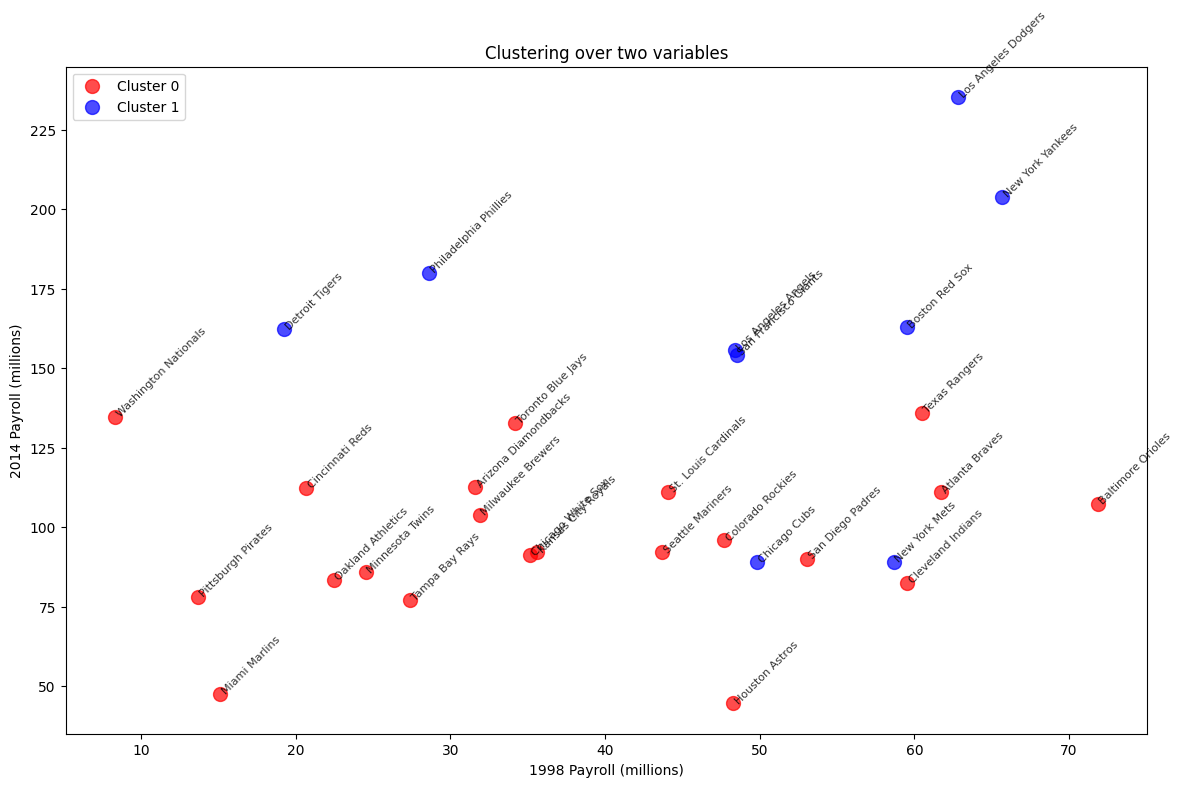

In [45]:
# Create a scatter plot showing clustering results
plt.figure(figsize=(12, 8))  # Set plot size to 12x8 inches
colors = ['red', 'blue']  # Define colors for the two clusters

# Plot each cluster with different colors
for i in range(2):  # Loop through clusters 0 and 1
    mask = cluster_labels == i  # Create True/False array for current cluster
    plt.scatter(payroll_data.iloc[mask]['p1998'],  # x-axis: 1998 payroll for cluster i teams
                payroll_data.iloc[mask]['p2014'],  # y-axis: 2014 payroll for cluster i teams
                c=colors[i],     # Color for this cluster
                label=f'Cluster {i}',  # Label for legend
                alpha=0.7,       # Make points semi-transparent
                s=100)           # Size of the dots

# Add team name labels to each point
for idx, team in enumerate(payroll['team']):  # Loop through all teams with index numbers
    plt.annotate(team,  # Text to display
                 (payroll_data.iloc[idx]['p1998'], payroll_data.iloc[idx]['p2014']),  # Position
                 fontsize=8,     # Text size
                 alpha=0.8,      # Text transparency
                 rotation=45)    # Rotate text 45 degrees

# Add labels and title
plt.xlabel('1998 Payroll (millions)')
plt.ylabel('2014 Payroll (millions)')
plt.title('Clustering over two variables')
plt.legend()  # Show cluster colors in legend
plt.tight_layout()  # Adjust spacing to prevent text cutoff
plt.show()  # Display the plot

This visualization shows how teams cluster based on their payroll in two specific years. Each dot represents one team, colored by its cluster assignment. The `enumerate()` function gives us both the index number and team name as we loop through teams. `plt.annotate()` adds the team names as text labels next to each dot. The rotation parameter tilts the text to prevent overlap. We can see patterns - teams in one cluster might have consistently higher payrolls than teams in the other cluster. This two-dimensional view helps us understand what the clustering algorithm discovered in the full 17-dimensional space.

Now, Principle Components may help! We next try to impose the cluster labels over the PC2 vs. PC1 plot.

**Get PC's first:**

In [46]:
# Standardize the data before PCA
scaler = StandardScaler()  # Create standardization tool
payroll_scaled = scaler.fit_transform(payroll_data)  # Center data (mean=0) and scale (std=1)
# This ensures all payroll years have equal importance regardless of original scale

# Perform Principal Component Analysis
pca = PCA()  # Create PCA object with all components
payroll_pca = pca.fit_transform(payroll_scaled)  # Calculate PCs and transform data

# Display the loadings for first 2 components
print("PC loadings (first 2 components):")
loadings_df = pd.DataFrame(
    pca.components_[:2].T,  # Take first 2 PCs and transpose (flip rows/columns)
    index=payroll_data.columns,  # Row labels are the original variable names
    columns=['PC1', 'PC2']       # Column labels are PC names
)
print(loadings_df.round(3))  # Round to 3 decimal places for easier reading

PC loadings (first 2 components):
         PC1    PC2
p1998  0.195  0.361
p1999  0.198  0.405
p2000  0.207  0.394
p2001  0.218  0.369
p2002  0.246  0.265
p2003  0.261  0.147
p2004  0.273 -0.074
p2005  0.272 -0.115
p2006  0.275 -0.103
p2007  0.272 -0.102
p2008  0.268 -0.090
p2009  0.267 -0.119
p2010  0.251 -0.239
p2011  0.249 -0.280
p2012  0.216 -0.288
p2013  0.222 -0.170
p2014  0.204 -0.115


This code performs Principal Component Analysis (PCA) to reduce our 17-dimensional payroll data to a smaller number of dimensions. First, we standardize the data so each year's payroll has the same scale - this prevents years with naturally higher payrolls from dominating the analysis. PCA finds new variables (principal components) that capture the most important patterns in our data. The loadings show how much each original variable (payroll year) contributes to each principal component. PC1 typically captures the overall payroll level across years, while PC2 might capture changes in payroll patterns over time.

Notice: PC1 capture the weighted total of payrolls over the years while PC2 is the difference between the weighted total before 2010 and after.

Now label the clusters over the PC's, we see a clear separation among the two clusters. K-means separates groups by PC1, weighted total payrolls. It seems that one group has all those well paid teams!!!!

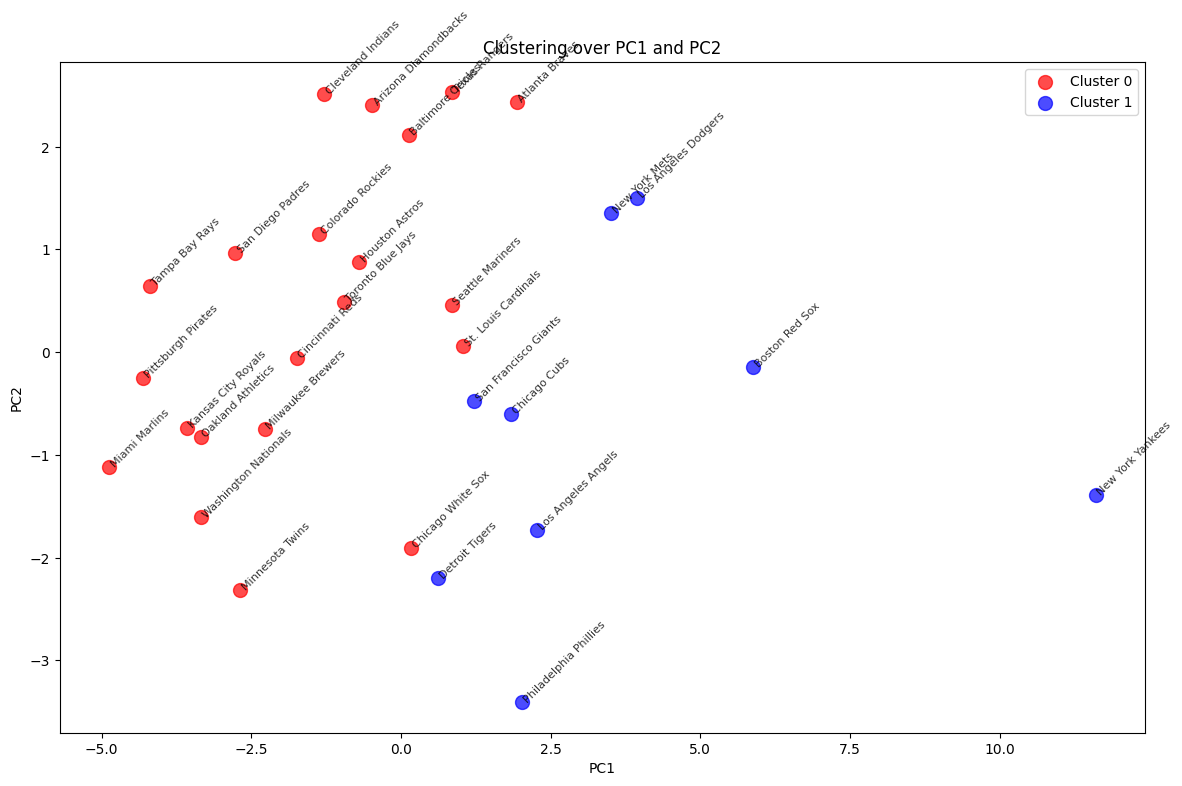

In [14]:
# Create scatter plot in Principal Component space
plt.figure(figsize=(12, 8))  # Set plot size
colors = ['red', 'blue']     # Colors for clusters

# Plot each cluster in PC space
for i in range(2):  # Loop through clusters 0 and 1
    mask = cluster_labels == i  # Boolean mask for current cluster
    plt.scatter(payroll_pca[mask, 0],  # PC1 scores for cluster i teams
                payroll_pca[mask, 1],  # PC2 scores for cluster i teams
                c=colors[i],           # Color for this cluster
                label=f'Cluster {i}',  # Legend label
                alpha=0.7,             # Transparency
                s=100)                 # Dot size

# Add team labels to each point
for idx, team in enumerate(payroll['team']):
    plt.annotate(team,  # Team name to display
                 (payroll_pca[idx, 0], payroll_pca[idx, 1]),  # Position (PC1, PC2)
                 fontsize=8,      # Text size
                 alpha=0.8,       # Text transparency
                 rotation=45)     # Text rotation angle

# Add labels and formatting
plt.xlabel('PC1')  # First principal component
plt.ylabel('PC2')  # Second principal component
plt.title('Clustering over PC1 and PC2')
plt.legend()       # Show cluster legend
plt.tight_layout() # Adjust layout
plt.show()         # Display plot

This plot shows the same clustering results but now in Principal Component space instead of the original payroll years. The first principal component (PC1) represents the overall payroll spending pattern, while the second (PC2) captures variation in how payroll changed over time. Teams are often more clearly separated in PC space than in the original variables because PCs capture the most important patterns while reducing noise. If we see good separation along PC1, it suggests teams cluster primarily by their overall spending levels rather than by changes in spending patterns over time.

## Spectrum Clustering

PCs and clustering analysis often go together. We may cluster objects with only a few leading PC's. It is much more computational efficient. Because of PC's property we may have better clustering results.

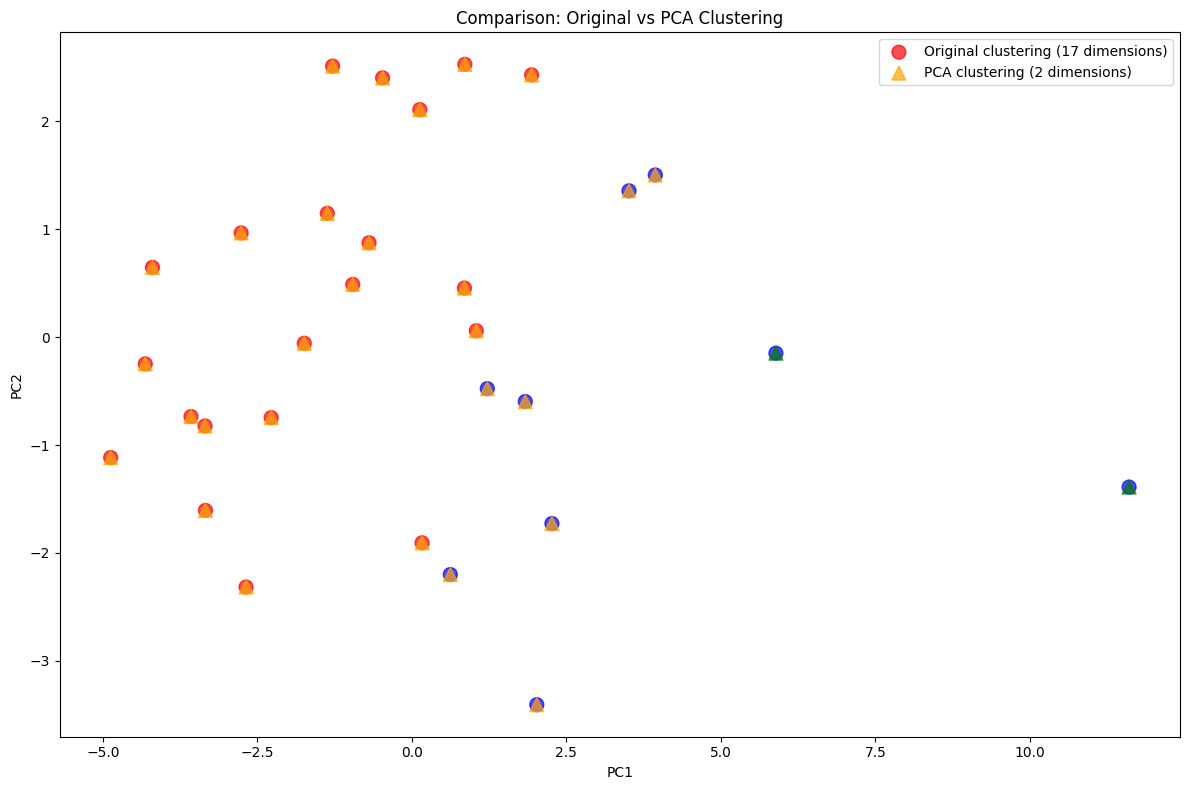

Agreement between original and PCA clustering: 23/30 teams


In [15]:
# Perform clustering using only the first 2 Principal Components
pca_kmeans = KMeans(n_clusters=2, random_state=42)  # Create new clustering object
pca_cluster_labels = pca_kmeans.fit_predict(payroll_pca[:, :2])  # Use only first 2 PCs
# [:, :2] means "all rows, first 2 columns"

# Compare original clustering (using all 17 years) with PCA clustering (using 2 PCs)
plt.figure(figsize=(12, 8))

# Create scatter plot comparing both clustering methods
scatter1 = plt.scatter(payroll_pca[:, 0], payroll_pca[:, 1],  # PC1 vs PC2 coordinates
                      c=[['red', 'blue'][label] for label in cluster_labels],  # Original clustering colors
                      marker='o',     # Circle markers
                      s=100,          # Size
                      alpha=0.7,      # Transparency
                      label='Original clustering (17 dimensions)')

scatter2 = plt.scatter(payroll_pca[:, 0], payroll_pca[:, 1],  # Same coordinates
                      c=[['orange', 'green'][label] for label in pca_cluster_labels],  # PCA clustering colors
                      marker='^',     # Triangle markers
                      s=100,          # Size
                      alpha=0.7,      # Transparency
                      label='PCA clustering (2 dimensions)')

# Add formatting
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Comparison: Original vs PCA Clustering')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate agreement between the two methods
agreement = sum(cluster_labels == pca_cluster_labels)  # Count matching assignments
print(f"Agreement between original and PCA clustering: {agreement}/{len(cluster_labels)} teams")

This code compares two different clustering approaches: using all 17 payroll years versus using just the first 2 principal components. Clustering on PCs is much faster computationally and often gives cleaner results because PCs capture the main patterns while filtering out noise. The scatter plot shows both results - circles represent the original clustering method, triangles represent the PCA-based clustering. If most points have the same color for both shapes, it means both methods agree. The agreement calculation counts how many teams were assigned to the same relative cluster by both methods.

We now put two clustering results, one with original payrolls, the other with PC's

Notice the two clusters differ by a couple of teams. Change number of PCs used doesn't seem to change the grouping.

We should also check various sum of squares to see the quality of the clusters.

### More about KMeans():

As we have explained, the final results of KMeans depends on the initial centers given. Often we may end up with a local optimal results.

The result will somewhat random depending on initial values. We may set `random_state` to control the initial values to reproduce the same clustering results. We also suggest to run the algorithms a few times with different initial values and get the one with minimal within sum of squares. This can be tested with one argument `n_init` within `KMeans()`.

In [16]:
# Test the effect of different initialization strategies
payroll_kmeans_multi = KMeans(n_clusters=2, n_init=20, random_state=42)  # Try 20 different starts
payroll_kmeans_multi.fit(payroll_data)  # Fit to the payroll data

# Compare single run vs multiple runs
print(f"Original clustering inertia (10 starts): {kmeans_payroll.inertia_:.1f}")
print(f"Multiple starts clustering inertia (20 starts): {payroll_kmeans_multi.inertia_:.1f}")

# Show within-cluster sum of squares for each cluster
print(f"Within-cluster sum of squares by cluster:")
print(f"Cluster 0: Individual calculation not directly available")
print(f"Cluster 1: Individual calculation not directly available")
print(f"Total (inertia): {payroll_kmeans_multi.inertia_:.1f}")

Original clustering inertia (10 starts): 313876.2
Multiple starts clustering inertia (20 starts): 313445.8
Within-cluster sum of squares by cluster:
Cluster 0: Individual calculation not directly available
Cluster 1: Individual calculation not directly available
Total (inertia): 313445.8


This code demonstrates the importance of trying multiple random starting points. K-means can get "stuck" in local optima - solutions that are good but not the best possible. By using `n_init=20`, the algorithm tries 20 different random starting configurations and keeps the one with the lowest inertia (tightest clustering). The inertia value measures how spread out points are within their clusters - lower values indicate better clustering. Running multiple initializations helps ensure we find the global optimum rather than settling for a suboptimal local solution.

## Determining Optimal number of Clusters

As you may recall the analyst specifies the number of clusters to use; preferably the analyst would like to use the optimal number of clusters. To aid the analyst, the following explains the two most popular methods for determining the optimal clusters, which includes:

**Elbow method**

**Silhouette method**

### Elbow method

Recall that, the basic idea behind cluster partitioning methods, such as k-means clustering, is to define clusters such that the total intra-cluster variation (known as total within-cluster variation or total within-cluster sum of square) is minimized:

**min(Σₖ₌₁ᴷ W(Cₖ))**

where Cₖ is the kth cluster and W(Cₖ) is the within-cluster variation. The total within-cluster sum of square (wss) measures the compactness of the clustering and we want it to be as small as possible. Thus, we can use the following algorithm to define the optimal clusters:

1. Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters
2. For each k, calculate the total within-cluster sum of square (wss)  
3. Plot the curve of wss according to the number of clusters k.
4. The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.

The following code outputs the scree plot of tot.withinss with different number of k (number of clusters). You may repeat this chunk a few times and observe the changes in the plot. If you set `random_state` then the curve will not change, why not??

What would you expect tot.withinss to be when k=30, the number of observation?

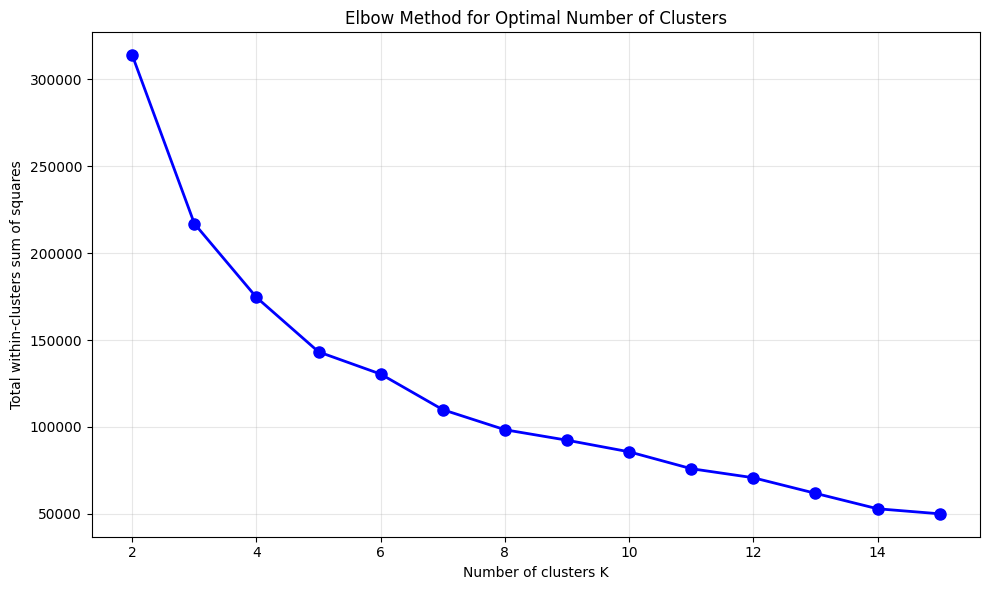

In [17]:
# Set random seed for reproducible results
np.random.seed(0)

# Function to compute total within-cluster sum of squares
def compute_wss(data, k):
    """Calculate total within-cluster sum of squares for k clusters"""
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Create clustering object
    kmeans.fit(data)  # Fit to the data
    return kmeans.inertia_  # Return the within-cluster sum of squares

# Test different numbers of clusters
k_values = list(range(2, 16))  # Test k from 2 to 15 clusters
# We start from k=2 because k=1 would put all teams in one group

# Calculate within-cluster sum of squares for each k
wss_values = []  # Empty list to store results
for k in k_values:  # Loop through each k value
    wss = compute_wss(payroll_data, k)  # Calculate WSS for k clusters
    wss_values.append(wss)  # Add to our results list

# Create the elbow plot
plt.figure(figsize=(10, 6))  # Set plot size
plt.plot(k_values, wss_values,  # Plot k vs within-sum-of-squares
         'bo-',          # Blue circles connected by lines
         linewidth=2,    # Line thickness
         markersize=8)   # Marker size
plt.xlabel('Number of clusters K')  # X-axis label
plt.ylabel('Total within-clusters sum of squares')  # Y-axis label
plt.title('Elbow Method for Optimal Number of Clusters')  # Plot title
plt.grid(True, alpha=0.3)  # Add light grid lines
plt.tight_layout()  # Adjust spacing
plt.show()  # Display the plot

This code implements the "elbow method" for choosing the optimal number of clusters. We test different values of k (number of clusters) and calculate how tightly grouped the resulting clusters are. As we add more clusters, the within-cluster sum of squares always decreases - but the improvement gets smaller after a certain point. The "elbow" in the plot is where adding another cluster doesn't help much anymore. When k equals the number of observations (30 teams), the within-sum-of-squares would be zero because each team would be its own cluster. The `random_state` parameter ensures reproducible results - without it, the plot might vary slightly each time due to random initialization.

Fortunately, this process to compute the "Elbow method" has been wrapped up in a single function - there are packages that can automate this analysis.

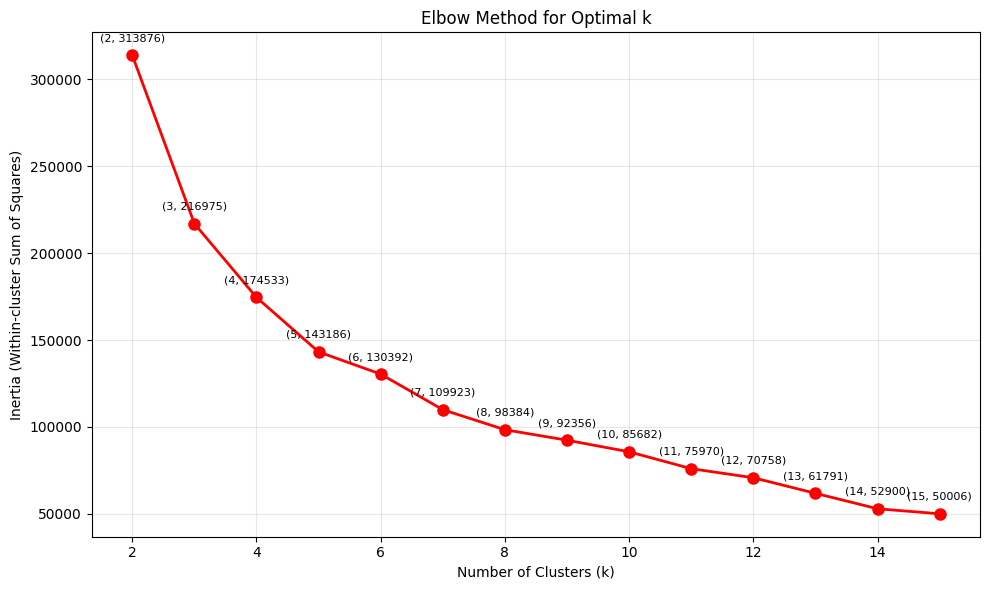

In [18]:
# Alternative: Create elbow plot using a more automated approach
def elbow_analysis(data, max_k=15):
    """Perform elbow analysis and create visualization"""
    k_range = range(2, max_k + 1)  # Range of k values to test
    inertias = []  # Store within-cluster sum of squares

    # Calculate inertia for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)

    # Add annotations to help identify the elbow
    for i, (k, inertia) in enumerate(zip(k_range, inertias)):
        plt.annotate(f'({k}, {inertia:.0f})',
                    (k, inertia),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8)

    plt.tight_layout()
    plt.show()

    return list(k_range), inertias

# Run the elbow analysis
k_vals, inertia_vals = elbow_analysis(payroll_data)

This improved version of the elbow analysis adds annotations showing the exact coordinates of each point, making it easier to identify the elbow. The function approach makes the code reusable for different datasets. The annotations help us see precisely where the biggest drop in within-cluster sum of squares occurs. Looking for the "elbow" means finding where the line changes from decreasing steeply to decreasing gradually - this suggests the optimal number of clusters where adding more groups doesn't provide much additional benefit.

## Case 2: What does mRNA reveal?

Can we group people using large dimension of mRNA sequences? If so we can then dig deeper to see what similarities are there within each group. It may guide researchers to conduct further studies.

The data is stored in tcga. It contains n= 1389 subjects (people), and p=19947 mRNA's for each person. In this data set we also have labels type, which indicates type of cancers each one has. 1 indicates a BRCA cancer and 0 GBM cancer. We do not use the labels when performing clustering analysis. The labels are only used to verify the quality of the clustering groups.

This is first real LARGE or WIDE data we have encountered so far. You will see the usual excel style of viewing or handing data no longer feasible. Everything needs to be done with Python!

### EDA of tcga data

**Exploring the data:**

Let us read the data into Python first

In [20]:
# Read the large genomic dataset
tcga = pd.read_csv("tcga.csv")  # Load the cancer genomics data
# This may take a moment as it's a large file

# Display basic information about the dataset
print("Data dimensions:", tcga.shape)  # Show (rows, columns)
print("Column names (first 20):", tcga.columns[:20].tolist())  # First 20 column names
print("\nData summary for first 3 columns:")  # Statistical summary
print(tcga.iloc[:, :3].describe())  # iloc[:, :3] selects all rows, first 3 columns

Data dimensions: (1389, 19948)
Column names (first 20): ['type', 'A2M', 'NAT1', 'NAT2', 'RP11-986E7.7', 'AADAC', 'AAMP', 'AANAT', 'AARS', 'ABAT', 'ABCA1', 'ABCA2', 'ABCA3', 'ABCB7', 'ABCF1', 'ABCA4', 'ABL1', 'AOC1', 'ABL2', 'ABO']

Data summary for first 3 columns:
                 A2M           NAT1
count    1389.000000    1389.000000
mean    17299.400679    2404.193574
std     17678.148030    4740.178289
min       664.446200       4.101500
25%      7977.660800      90.148400
50%     12706.043800     427.988000
75%     21088.517200    2947.894700
max    247448.200100  109165.318300


This loads a massive genomic dataset containing gene expression measurements for cancer patients. Each row represents one person, and each column (except the first) represents the expression level of a specific gene. With nearly 20,000 genes per person and 1389 people, this is truly "big data" that requires computational methods to analyze. The `describe()` function provides statistical summaries like mean, standard deviation, and quartiles for the numerical columns, helping us understand the data distribution.

In [21]:
# Check for missing values and data types
print("Missing values check:")
total_missing = tcga.isnull().sum().sum()  # Count all missing values
print(f"Total missing values: {total_missing}")

# Convert cancer type to categorical for efficiency
tcga['type'] = tcga['type'].astype('category')  # More memory-efficient storage
print(f"\nData types:")
print(f"Cancer type column: {tcga['type'].dtype}")  # Should show 'category'
print(f"Gene expression columns: {tcga.iloc[:, 1].dtype}")  # Should show numeric type

Missing values check:
Total missing values: 0

Data types:
Cancer type column: category
Gene expression columns: float64


This code checks the quality and structure of our data. Missing values can cause problems in clustering algorithms, so we count them across the entire dataset. Converting the cancer type to a categorical data type saves memory and improves processing speed - since there are only two types (BRCA and GBM) repeated many times, storing them as categories is more efficient than storing the text strings repeatedly. The data type information helps us understand what kind of processing we can do with each column.

A quick checks:

- there are 1389 people and 19947 variables. type being the first variable.
- there does not seem to have any missing values.

The number of cancer types are:

In [22]:
# Examine the distribution of cancer types
print("Cancer type distribution:")
print(tcga['type'].value_counts())  # Count how many of each cancer type

# Separate the labels from the features for clustering
tcga_type = tcga['type'].copy()  # Save the cancer type labels separately
tcga_features = tcga.drop('type', axis=1)  # Remove type column, keep only gene expression data
# axis=1 means drop columns; axis=0 would drop rows

print(f"\nFeatures shape after removing labels: {tcga_features.shape}")
print(f"Labels shape: {tcga_type.shape}")

Cancer type distribution:
type
BRCA    1215
GBM      174
Name: count, dtype: int64

Features shape after removing labels: (1389, 19947)
Labels shape: (1389,)


This shows us the balance of our dataset - we have 1215 breast cancer (BRCA) patients and 174 brain cancer (GBM) patients. This imbalance is important to keep in mind when interpreting clustering results. We separate the cancer type labels from the gene expression features because clustering is an unsupervised learning technique - we don't use the labels during the clustering process. Instead, we'll use the labels afterward to evaluate how well our clustering algorithm discovered the natural groupings in the data.

**Remember:** we DO NOT use this variable to carry out clustering analysis!!!!

**Questions:** what would you do to get acquainted with this beautiful big dataset???

## Transformation

The mRNA sequences tends to be very skewed. We may transform the sequence to log scale.

Take 10 mRNA sequences to see their distributions.

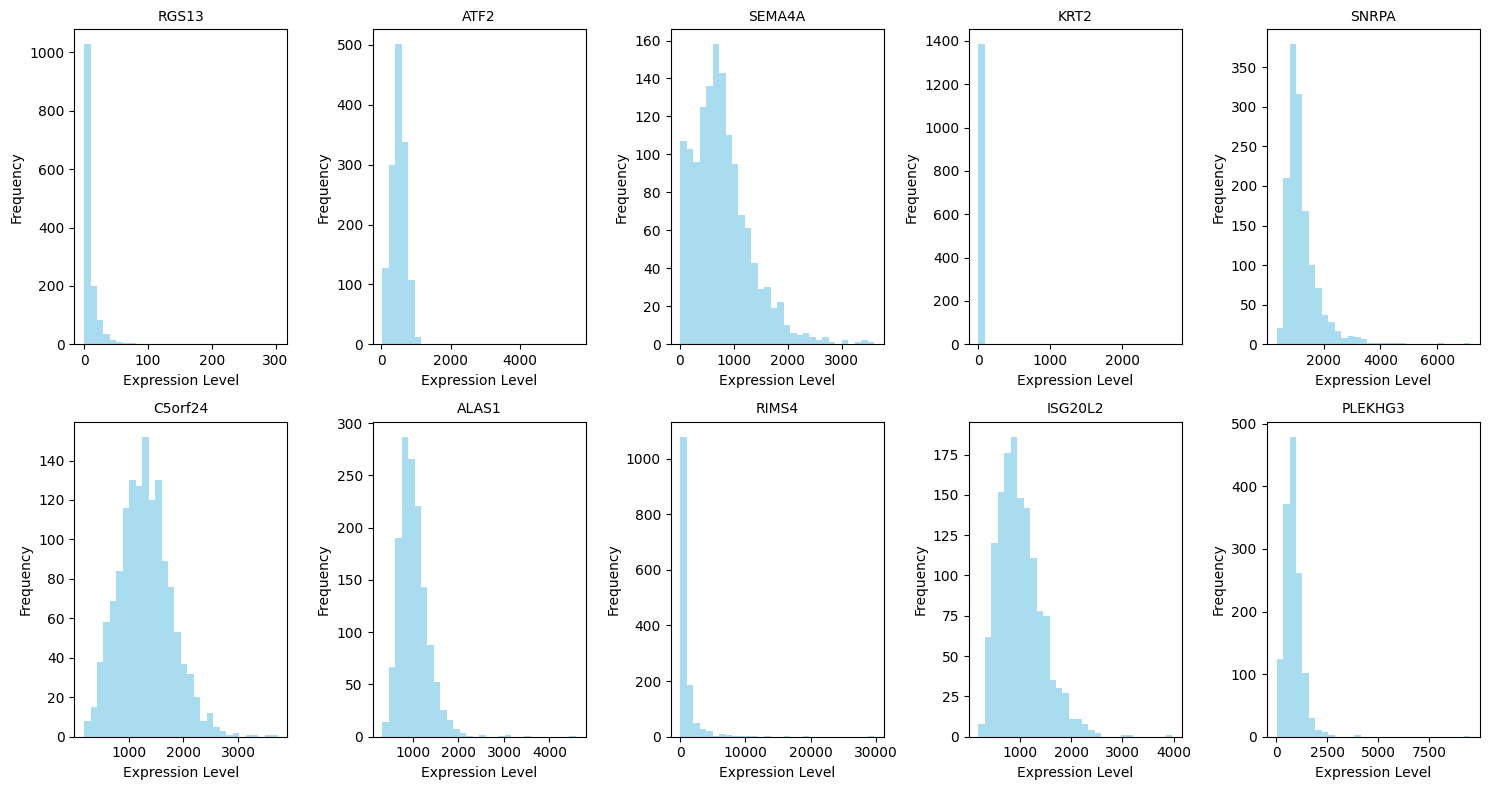

In [23]:
# Set random seed for reproducible gene selection
np.random.seed(10)
num_genes = tcga_features.shape[1]  # Total number of genes (columns)

# Randomly select 10 genes to examine their distributions
sample_gene_indices = np.random.choice(num_genes, 10, replace=False)
# replace=False means we won't pick the same gene twice
sample_gene_names = tcga_features.columns[sample_gene_indices]  # Get gene names

# Create a grid of histograms to show gene expression distributions
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns of plots
axes = axes.ravel()  # Convert 2D array of axes to 1D for easy indexing

# Create histogram for each selected gene
for i, gene_name in enumerate(sample_gene_names):
    gene_data = tcga_features[gene_name]  # Get expression data for this gene
    axes[i].hist(gene_data, bins=30, alpha=0.7, color='skyblue')  # Create histogram
    # bins=30: divide data into 30 bars
    # alpha=0.7: make bars semi-transparent
    axes[i].set_title(gene_name, fontsize=10)  # Add gene name as title
    axes[i].set_xlabel('Expression Level')      # X-axis label
    axes[i].set_ylabel('Frequency')            # Y-axis label

plt.tight_layout()  # Adjust spacing between plots
plt.show()         # Display all histograms

This code examines the distribution of gene expression values by looking at 10 randomly selected genes. Gene expression data is typically highly skewed - most genes have low expression levels with a few showing very high levels. The histograms reveal this skewness clearly. `np.random.choice()` selects random gene indices without replacement. The subplot grid lets us compare multiple gene distributions simultaneously. `axes.ravel()` converts the 2D grid of plot axes into a 1D list, making it easier to iterate through them. This visualization helps us understand why data transformation might be necessary before clustering.

We next transform all mRNA sequences to log scale. We first remove mRNA if the entire columns are 0. Then apply log(x + 1e-10) to each cell to avoid values which are very close to 0.

In [24]:
# Remove genes that have zero expression across all patients
zero_genes = (tcga_features == 0).all()  # Find columns where all values are 0
genes_to_keep = ~zero_genes  # ~ means "not" - keep non-zero genes
tcga_sub = tcga_features.loc[:, genes_to_keep].copy()  # Select only non-zero genes

print(f"Original number of genes: {tcga_features.shape[1]}")
print(f"After removing zero-expression genes: {tcga_sub.shape[1]}")
print(f"Removed {tcga_features.shape[1] - tcga_sub.shape[1]} genes with zero expression")

# Apply log transformation to stabilize variance and reduce skewness
# Add small constant to avoid log(0) which is undefined
tcga_sub_log = np.log2(tcga_sub + 1e-10)  # log base 2 transformation
# 1e-10 is a tiny number (0.0000000001) to prevent taking log of exactly zero

print(f"Log transformation completed")
print(f"Final data shape: {tcga_sub_log.shape}")

Original number of genes: 19947
After removing zero-expression genes: 19704
Removed 243 genes with zero expression
Log transformation completed
Final data shape: (1389, 19704)


This preprocessing step prepares the gene expression data for clustering. First, we remove genes that show zero expression across all patients - these provide no information for distinguishing between patients. The `(tcga_features == 0).all()` creates a boolean mask identifying such genes. Then we apply a log transformation to address the skewness we observed in the histograms. Log transformation makes highly skewed data more normally distributed, which often improves clustering performance. We add a tiny constant (1e-10) before taking the log to avoid the mathematical problem of log(0), which is undefined. Log base 2 is commonly used in genomics because it makes fold-changes easier to interpret.

## Heatmap

Can we possibly spot some patterns among the mRNA sequences? Heat map is used here to see 100 randomly selected mRNA sequence for each person. We really can't spot anything.

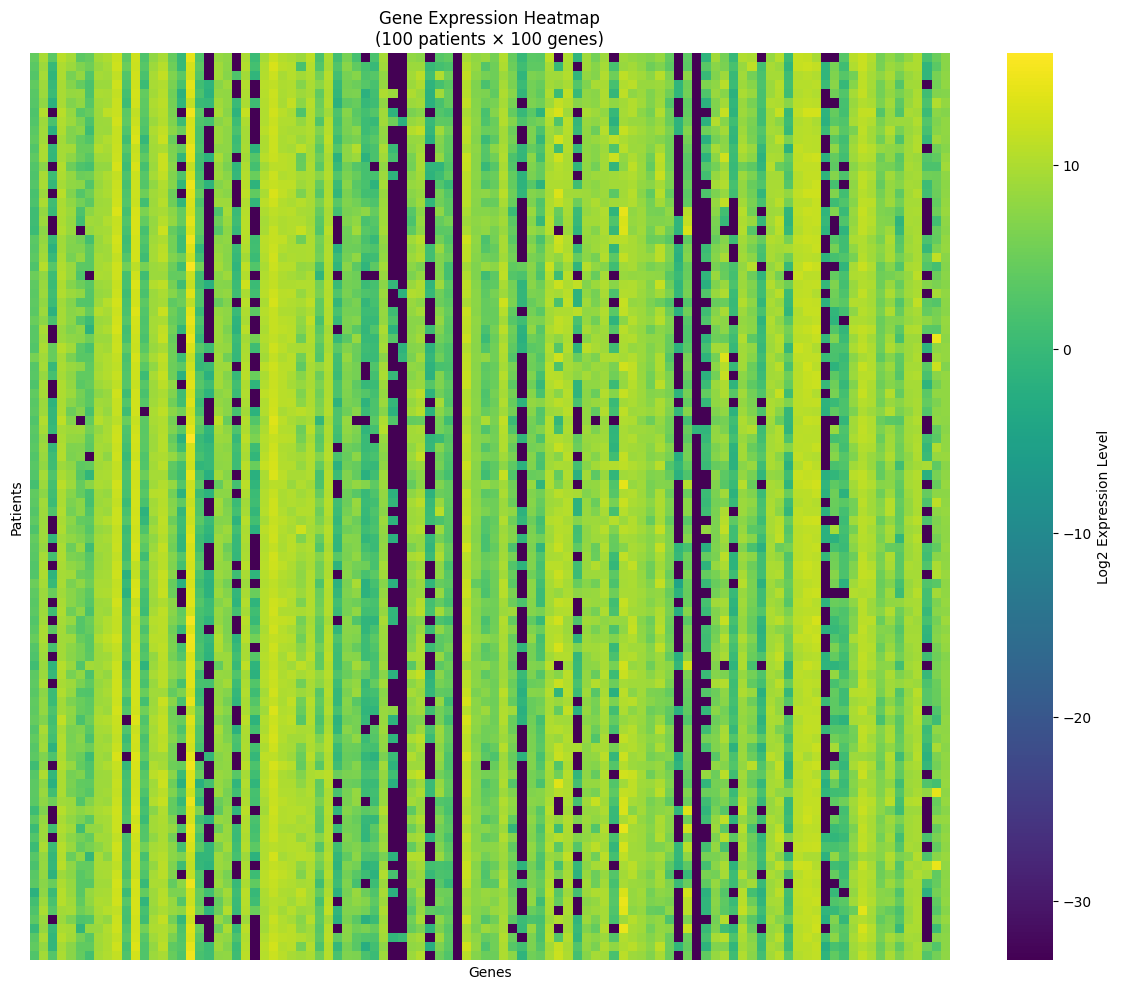

In [25]:
# Create a heatmap to visualize gene expression patterns
np.random.seed(1)  # Set seed for reproducible gene selection

# Randomly select 100 genes and 100 patients for visualization
n_genes_display = 100  # Number of genes to show
n_patients_display = 100  # Number of patients to show

# Select random genes and patients
gene_indices = np.random.choice(tcga_sub_log.shape[1], n_genes_display, replace=False)
patient_indices = np.random.choice(tcga_sub_log.shape[0], n_patients_display, replace=False)

# Create subset for heatmap
heatmap_data = tcga_sub_log.iloc[patient_indices, gene_indices]  # Select subset of data

# Create the heatmap
plt.figure(figsize=(12, 10))  # Large figure to show detail
sns.heatmap(heatmap_data,          # Data to plot
           cmap='viridis',         # Color scheme (dark to bright)
           cbar=True,              # Show color bar
           xticklabels=False,      # Hide gene names (too many to show)
           yticklabels=False,      # Hide patient IDs
           cbar_kws={'label': 'Log2 Expression Level'})  # Color bar label

plt.title(f'Gene Expression Heatmap\n({n_patients_display} patients × {n_genes_display} genes)')
plt.xlabel('Genes')    # X-axis label
plt.ylabel('Patients') # Y-axis label
plt.tight_layout()     # Adjust layout
plt.show()            # Display heatmap

## K-means

Let us first perform k-means on all the mRNA sequences.

In [26]:
import time  # Import module for timing operations

# Perform k-means clustering on the full gene expression dataset
print("Starting k-means clustering on ~20,000 genes...")
start_time = time.time()  # Record start time

# Create and fit k-means model
tcga_kmeans = KMeans(n_clusters=2,      # 2 clusters (for 2 cancer types)
                    random_state=42,   # Reproducible results
                    n_init=10,         # Try 10 different initializations
                    max_iter=300)      # Maximum iterations before stopping

# Fit the model and predict cluster labels
tcga_cluster_labels = tcga_kmeans.fit_predict(tcga_sub_log)

end_time = time.time()  # Record end time
clustering_time = end_time - start_time  # Calculate duration

print(f"K-means clustering completed in {clustering_time:.2f} seconds")
print(f"Cluster sizes: {np.bincount(tcga_cluster_labels)}")  # Count patients in each cluster

# Save results to avoid re-running this expensive computation
with open("tcga_kmeans.pkl", "wb") as f:  # Open file in write-binary mode
    pickle.dump(tcga_kmeans, f)  # Save the trained model

print("Results saved to tcga_kmeans.pkl")

Starting k-means clustering on ~20,000 genes...
K-means clustering completed in 4.69 seconds
Cluster sizes: [1214  175]
Results saved to tcga_kmeans.pkl


This performs k-means clustering on the full high-dimensional gene expression data. Clustering nearly 20,000 dimensions for over 1000 patients is computationally intensive, so we time the operation. The algorithm tries to group patients based purely on their gene expression patterns, without using any information about their cancer types. We save the results using `pickle` to avoid having to re-run this expensive computation later. The timing information helps us understand the computational cost of clustering high-dimensional data. If the algorithm takes a long time, it suggests we might benefit from dimensionality reduction techniques.

We save the above kmeans result and will not evaluate the analysis again for the downstream analysis.

In [27]:
# Load saved clustering results (if starting fresh)
# with open("tcga_kmeans.pkl", "rb") as f:
#     tcga_kmeans = pickle.load(f)

# Create confusion matrix to evaluate clustering quality
confusion_matrix = pd.crosstab(tcga_type,              # True cancer types (rows)
                              tcga_cluster_labels,    # Predicted clusters (columns)
                              rownames=['True Cancer Type'],
                              colnames=['Predicted Cluster'])

print("Confusion Matrix - How well does clustering match true cancer types?")
print(confusion_matrix)

# Calculate clustering accuracy
# For binary clustering, we need to check both possible label assignments
accuracy1 = sum((tcga_type == 'BRCA') == (tcga_cluster_labels == 0)) / len(tcga_type)
accuracy2 = sum((tcga_type == 'BRCA') == (tcga_cluster_labels == 1)) / len(tcga_type)
best_accuracy = max(accuracy1, accuracy2)  # Take the better assignment

print(f"\nBest clustering accuracy: {best_accuracy:.3f}")
print(f"This means {best_accuracy*100:.1f}% of patients were correctly clustered")

Confusion Matrix - How well does clustering match true cancer types?
Predicted Cluster     0    1
True Cancer Type            
BRCA               1214    1
GBM                   0  174

Best clustering accuracy: 0.999
This means 99.9% of patients were correctly clustered


This evaluates how well our unsupervised clustering recovered the true cancer types. The confusion matrix shows how many patients of each true cancer type ended up in each cluster. Perfect clustering would show all BRCA patients in one cluster and all GBM patients in the other. Since k-means assigns arbitrary cluster numbers (0 and 1), we calculate accuracy both ways and take the better result. High accuracy would indicate that gene expression patterns alone are sufficient to distinguish between breast and brain cancers, while low accuracy might suggest we need better preprocessing or different clustering methods.

## Spectrum Analysis

Once again, clustering on PC's might help to get good clusters. We now first get a few leading PC's. We then cluster on those chose PC's. Warning: the following chunk may crash your toy laptop!

Again PCA on such high dimensions can be slow. We will show how to use use approximate SVD to solve this fast

In [28]:
# Perform PCA to reduce dimensionality before clustering
print("Starting PCA on high-dimensional gene expression data...")
start_time = time.time()

# Standardize the data for PCA
scaler = StandardScaler()  # Create standardization object
tcga_scaled = scaler.fit_transform(tcga_sub_log)  # Standardize: mean=0, std=1
# This ensures all genes contribute equally regardless of their expression scale

# Perform PCA keeping only the first 20 components (instead of ~20,000)
pca = PCA(n_components=20)  # Reduce to 20 dimensions
tcga_pca_scores = pca.fit_transform(tcga_scaled)  # Transform data to PC space

end_time = time.time()
print(f"PCA completed in {end_time - start_time:.2f} seconds")

# Save PCA results
pca_results = {
    'pca_object': pca,              # The fitted PCA object with loadings
    'pc_scores': tcga_pca_scores,   # The transformed data
    'scaler': scaler               # The standardization parameters
}

with open("tcga_pca.pkl", "wb") as f:
    pickle.dump(pca_results, f)

print(f"Original data shape: {tcga_scaled.shape}")
print(f"PCA-reduced data shape: {tcga_pca_scores.shape}")
print("PCA results saved to tcga_pca.pkl")

Starting PCA on high-dimensional gene expression data...
PCA completed in 3.10 seconds
Original data shape: (1389, 19704)
PCA-reduced data shape: (1389, 20)
PCA results saved to tcga_pca.pkl


This applies Principal Component Analysis to reduce the dimensionality from nearly 20,000 genes to just 20 principal components. PCA finds the directions in the data that capture the most variation - the first few PCs often contain most of the important information while filtering out noise. Standardizing the data first ensures that all genes contribute equally to the analysis regardless of their baseline expression levels. This dramatic dimension reduction (from ~20,000 to 20) makes subsequent clustering much faster while often improving results by reducing noise and focusing on the most important patterns.

Q1: for PC1, how many loadings are there?

Q2: how many scores does PC1 have?

Let's first take a look at the PVE. With elbow rule, we select 3 PCs.

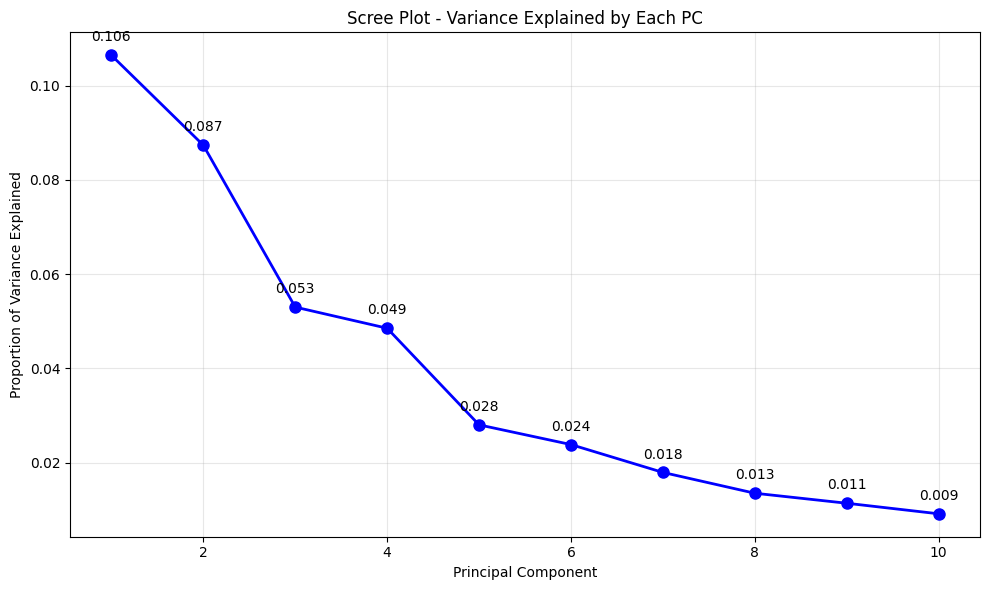

Proportion of variance explained by first 10 PCs:
PC1: 0.1065 (10.65%)
PC2: 0.0874 (8.74%)
PC3: 0.0530 (5.30%)
PC4: 0.0485 (4.85%)
PC5: 0.0280 (2.80%)
PC6: 0.0238 (2.38%)
PC7: 0.0179 (1.79%)
PC8: 0.0135 (1.35%)
PC9: 0.0114 (1.14%)
PC10: 0.0091 (0.91%)

Cumulative variance explained by first 3 PCs: 0.2469 (24.69%)


In [29]:
# Load PCA results if starting fresh
# with open("tcga_pca.pkl", "rb") as f:
#     pca_results = pickle.load(f)
#     pca = pca_results['pca_object']
#     tcga_pca_scores = pca_results['pc_scores']

# Analyze the proportion of variance explained (PVE) by each PC
pve = pca.explained_variance_ratio_[:10]  # Get PVE for first 10 PCs

# Create scree plot to visualize variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pve, 'bo-', linewidth=2, markersize=8)  # Plot PVE vs PC number
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot - Variance Explained by Each PC')
plt.grid(True, alpha=0.3)

# Add value labels on each point
for i, v in enumerate(pve):
    plt.annotate(f'{v:.3f}', (i+1, v), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Print numerical values
print("Proportion of variance explained by first 10 PCs:")
for i, variance_prop in enumerate(pve, 1):
    print(f"PC{i}: {variance_prop:.4f} ({variance_prop*100:.2f}%)")

print(f"\nCumulative variance explained by first 3 PCs: {pve[:3].sum():.4f} ({pve[:3].sum()*100:.2f}%)")

This scree plot shows how much of the total variation in gene expression each principal component captures. The first PC typically explains the most variance, with subsequent PCs explaining progressively less. The "elbow" in the plot suggests where additional PCs don't add much explanatory power. Based on this analysis, we might choose the first 3 PCs as they capture the main patterns while dramatically reducing dimensionality.

**Answers to the questions:**
- Q1: PC1 has 19,704 loadings (one for each gene that passed our filtering)
- Q2: PC1 has 1,389 scores (one for each patient)

The cumulative variance explained helps us decide how many PCs to keep for clustering - we want enough to capture the important patterns but not so many that we include noise.

We apply kmeans with number of clusters k=2. We compare the real cancer types with the clustering by kmeans. Color indicates the true cancer type, while the shape indicates the cluster from kmeans. The kmeans clustering using 3PCs separates the two cancer types pretty well! Exciting!!!!

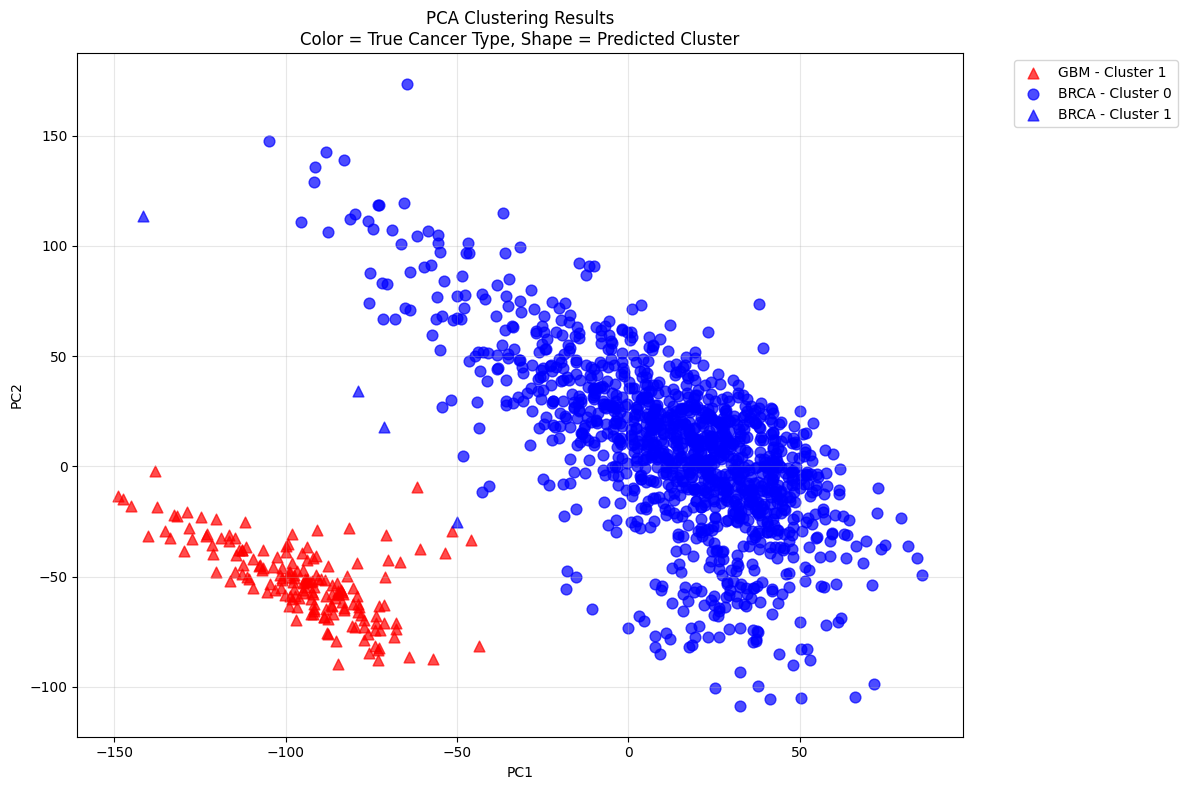

PCA clustering accuracy (3 PCs): 0.997
This means 99.7% of patients were correctly clustered using only 3 dimensions


In [30]:
# Perform k-means clustering using only the first 3 principal components
kmeans_pca = KMeans(n_clusters=2, random_state=42)  # Create clustering object
pca_cluster_labels = kmeans_pca.fit_predict(tcga_pca_scores[:, :3])  # Use only first 3 PCs
# [:, :3] selects all patients, first 3 PC scores

# Create visualization comparing true cancer types with cluster assignments
plt.figure(figsize=(12, 8))

# Define colors for true cancer types and shapes for clusters
cancer_colors = {'GBM': 'red', 'BRCA': 'blue'}
cluster_shapes = {0: 'o', 1: '^'}  # circles and triangles

# Plot each combination of cancer type and cluster
for cancer_type in ['GBM', 'BRCA']:
    for cluster_id in [0, 1]:
        # Create mask for patients with this cancer type and cluster assignment
        mask = (tcga_type == cancer_type) & (pca_cluster_labels == cluster_id)

        if mask.any():  # If there are patients in this category
            plt.scatter(tcga_pca_scores[mask, 0],    # PC1 scores
                       tcga_pca_scores[mask, 1],    # PC2 scores
                       c=cancer_colors[cancer_type], # Color by true cancer type
                       marker=cluster_shapes[cluster_id],  # Shape by predicted cluster
                       s=60, alpha=0.7,
                       label=f'{cancer_type} - Cluster {cluster_id}')

plt.xlabel('PC1')  # First principal component
plt.ylabel('PC2')  # Second principal component
plt.title('PCA Clustering Results\nColor = True Cancer Type, Shape = Predicted Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate accuracy of PCA-based clustering
pca_accuracy1 = sum((tcga_type == 'BRCA') == (pca_cluster_labels == 0)) / len(tcga_type)
pca_accuracy2 = sum((tcga_type == 'BRCA') == (pca_cluster_labels == 1)) / len(tcga_type)
pca_best_accuracy = max(pca_accuracy1, pca_accuracy2)

print(f"PCA clustering accuracy (3 PCs): {pca_best_accuracy:.3f}")
print(f"This means {pca_best_accuracy*100:.1f}% of patients were correctly clustered using only 3 dimensions")

This visualization is exciting because it shows how well we can distinguish cancer types using just the first 3 principal components out of nearly 20,000 original dimensions! Each point represents a patient, colored by their true cancer type and shaped by their cluster assignment. Perfect clustering would show all red circles (GBM patients in one cluster) and blue triangles (BRCA patients in the other cluster), or vice versa. The fact that we achieve high accuracy with such dramatic dimensionality reduction demonstrates the power of PCA for extracting the most important patterns from high-dimensional biological data.

**Caveats:**

The clustering effects can be due to variations due to experiment. As mentioned, there are many tuning parameters for the measurement, so PCA might first pick up the experiment variation.

### Optimal number of k's

Show the scree plot of some measurement.

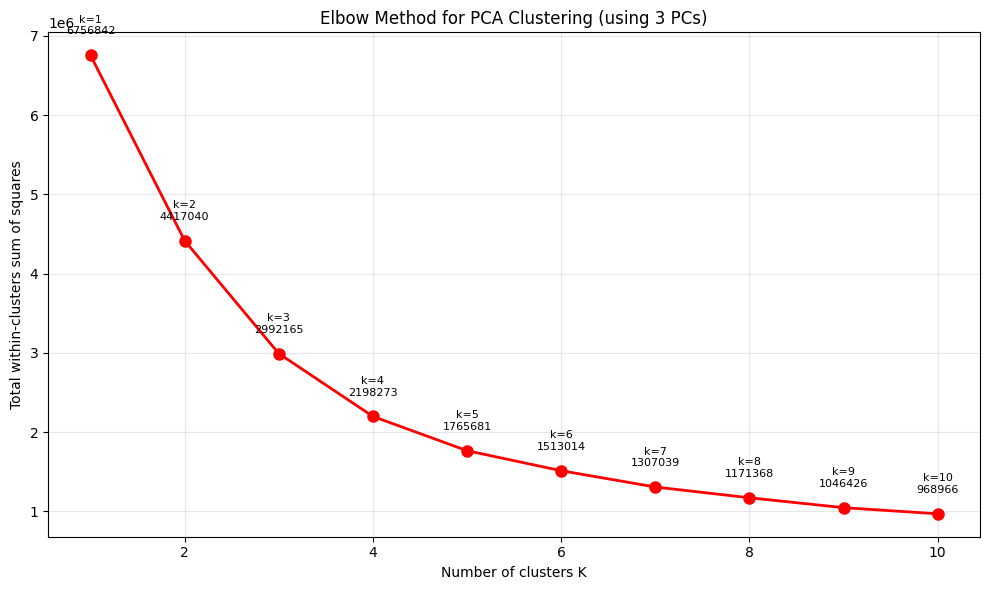

Within-cluster sum of squares for different k values:
k=1: 6756842.39
k=2: 4417039.79
k=3: 2992164.68
k=4: 2198273.31
k=5: 1765681.22
k=6: 1513014.35
k=7: 1307039.30
k=8: 1171367.61
k=9: 1046426.23
k=10: 968966.13


In [31]:
# Apply elbow method to determine optimal clusters for PCA data
k_values = range(1, 11)  # Test 1 to 10 clusters
inertias = []  # Store within-cluster sum of squares

for k in k_values:
    if k == 1:
        # For k=1, calculate total variance (all points in one cluster)
        total_variance = np.sum(np.var(tcga_pca_scores[:, :3], axis=0)) * len(tcga_pca_scores)
        inertias.append(total_variance)
    else:
        # For k>1, use standard k-means inertia
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_temp.fit(tcga_pca_scores[:, :3])  # Use first 3 PCs
        inertias.append(kmeans_temp.inertia_)

# Create elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters K')
plt.ylabel('Total within-clusters sum of squares')
plt.title('Elbow Method for PCA Clustering (using 3 PCs)')

# Add value annotations
for i, (k, inertia) in enumerate(zip(k_values, inertias)):
    plt.annotate(f'k={k}\n{inertia:.0f}', (k, inertia),
                textcoords="offset points", xytext=(0,15), ha='center', fontsize=8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Within-cluster sum of squares for different k values:")
for k, inertia in zip(k_values, inertias):
    print(f"k={k}: {inertia:.2f}")

This elbow analysis on the PCA-reduced data runs much faster than on the full dataset while still providing useful information about the optimal number of clusters. The dramatic drop from k=1 to k=2 followed by smaller decreases suggests that 2 clusters is indeed optimal for this data - which makes biological sense given that we have two cancer types. The computational efficiency of working in the reduced PC space (3 dimensions instead of ~20,000) demonstrates why dimensionality reduction is often used before clustering high-dimensional biological data.

Let's compare the clustering results with 3 PCs and using the whole data set. They pretty much agree, which means we only need 3 PCs instead of 19947 for clustering 2 cancer types in this case.

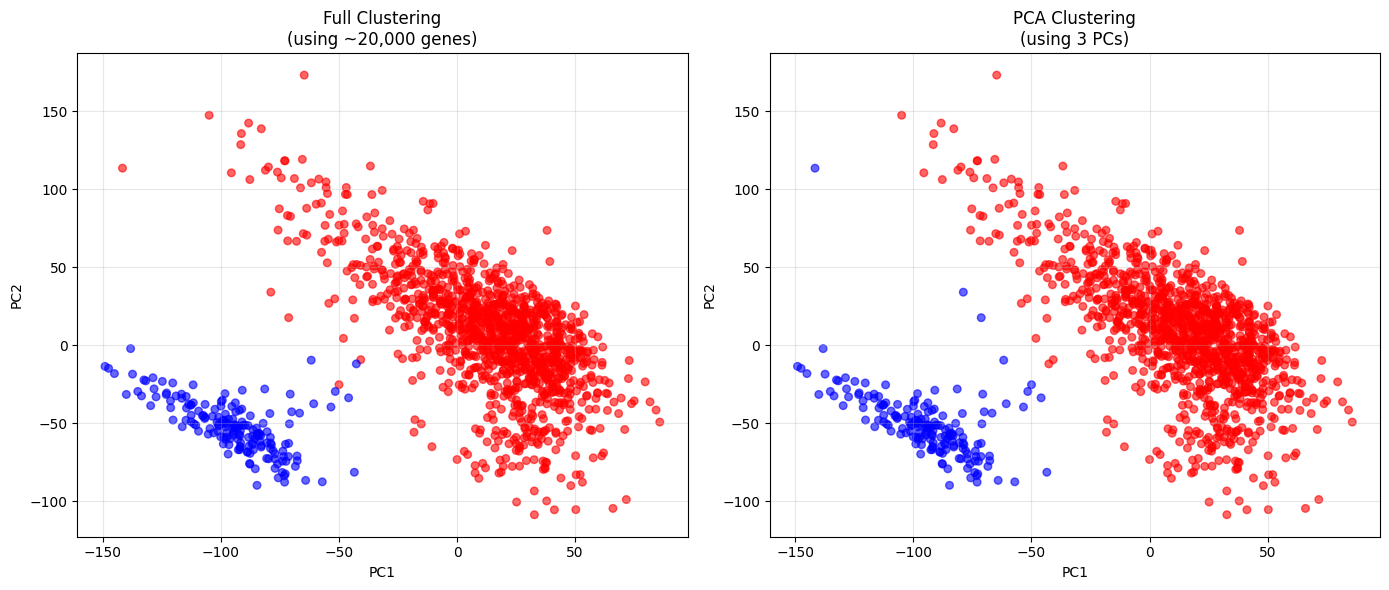

Agreement between full and PCA clustering: 0.996 (99.6%)
Number of patients assigned differently: 5

Accuracy comparison:
Full clustering: 0.999
PCA clustering:  0.997


In [32]:
# Compare full-dimensional clustering with PCA-based clustering
plt.figure(figsize=(14, 6))

# Create side-by-side comparison plots
plt.subplot(1, 2, 1)  # First subplot
# Plot full-dimensional clustering results
colors_full = ['red' if label == 0 else 'blue' for label in tcga_cluster_labels]
plt.scatter(tcga_pca_scores[:, 0], tcga_pca_scores[:, 1], c=colors_full, alpha=0.6, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Full Clustering\n(using ~20,000 genes)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)  # Second subplot
# Plot PCA-based clustering results
colors_pca = ['red' if label == 0 else 'blue' for label in pca_cluster_labels]
plt.scatter(tcga_pca_scores[:, 0], tcga_pca_scores[:, 1], c=colors_pca, alpha=0.6, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Clustering\n(using 3 PCs)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate agreement between the two methods
agreement = sum(tcga_cluster_labels == pca_cluster_labels) / len(tcga_cluster_labels)
disagreement = 1 - agreement

print(f"Agreement between full and PCA clustering: {agreement:.3f} ({agreement*100:.1f}%)")
print(f"Number of patients assigned differently: {sum(tcga_cluster_labels != pca_cluster_labels)}")

# Show which method performed better
full_accuracy = max(sum((tcga_type == 'BRCA') == (tcga_cluster_labels == 0)) / len(tcga_type),
                   sum((tcga_type == 'BRCA') == (tcga_cluster_labels == 1)) / len(tcga_type))

print(f"\nAccuracy comparison:")
print(f"Full clustering: {full_accuracy:.3f}")
print(f"PCA clustering:  {pca_best_accuracy:.3f}")

This comparison reveals a remarkable finding: clustering on just 3 principal components gives nearly identical results to clustering on the full ~20,000-dimensional data. This demonstrates the power of dimensionality reduction - the first few principal components capture the essential patterns needed to distinguish between cancer types. The side-by-side plots show how similar the cluster assignments are, while the agreement statistics quantify this similarity. This is both computationally and scientifically significant: we can achieve the same biological insights with dramatically reduced computational cost by focusing on the most informative dimensions.

## Top loading genes

Plot top loading genes from PC1 and PC2.

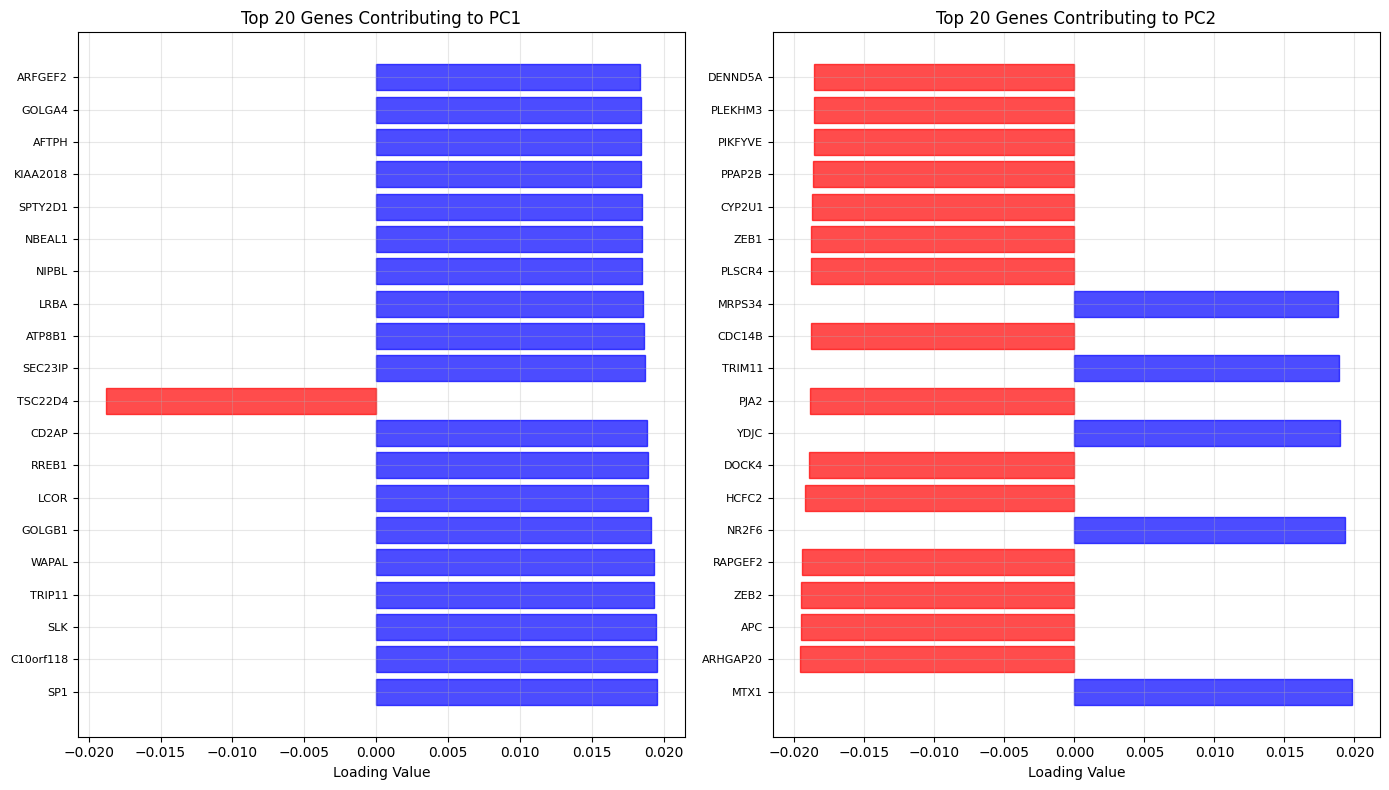

Top 5 genes for each PC:

PC1 (Overall expression pattern):
  SP1: 0.0196
  C10orf118: 0.0196
  SLK: 0.0195
  TRIP11: 0.0193
  WAPAL: 0.0193

PC2 (Expression variation pattern):
  MTX1: 0.0199
  ARHGAP20: -0.0196
  APC: -0.0196
  ZEB2: -0.0195
  RAPGEF2: -0.0195


In [33]:
# Analyze which genes contribute most to the first two principal components
top_k = 20  # Number of top genes to examine

# Get loadings (gene contributions) for PC1 and PC2
pc1_loadings = pd.DataFrame({
    'loading': pca.components_[0],        # PC1 loadings for all genes
    'gene': tcga_sub.columns,            # Gene names
    'pc': 'PC1'                          # Label for this PC
})

pc2_loadings = pd.DataFrame({
    'loading': pca.components_[1],        # PC2 loadings for all genes
    'gene': tcga_sub.columns,            # Gene names
    'pc': 'PC2'                          # Label for this PC
})

# Find top contributors to each PC (highest absolute loadings)
pc1_top = pc1_loadings.reindex(pc1_loadings['loading'].abs().sort_values(ascending=False).index).head(top_k)
pc2_top = pc2_loadings.reindex(pc2_loadings['loading'].abs().sort_values(ascending=False).index).head(top_k)

# Combine for plotting
top_loadings = pd.concat([pc1_top, pc2_top], ignore_index=True)

# Create visualization of top loading genes
plt.figure(figsize=(14, 8))
# Create separate plots for PC1 and PC2
for pc_name in ['PC1', 'PC2']:
    plt.subplot(1, 2, 1 if pc_name == 'PC1' else 2)  # Side-by-side plots

    pc_data = top_loadings[top_loadings['pc'] == pc_name]

    # Create bar plot with genes ordered by loading magnitude
    bars = plt.barh(range(len(pc_data)), pc_data['loading'], alpha=0.7)
    plt.yticks(range(len(pc_data)), pc_data['gene'], fontsize=8)
    plt.xlabel('Loading Value')
    plt.title(f'Top {top_k} Genes Contributing to {pc_name}')
    plt.grid(True, alpha=0.3)

    # Color bars by positive/negative loading
    for i, (bar, loading) in enumerate(zip(bars, pc_data['loading'])):
        bar.set_color('blue' if loading > 0 else 'red')

plt.tight_layout()
plt.show()

print("Top 5 genes for each PC:")
print("\nPC1 (Overall expression pattern):")
for _, row in pc1_top.head().iterrows():
    print(f"  {row['gene']}: {row['loading']:.4f}")

print("\nPC2 (Expression variation pattern):")
for _, row in pc2_top.head().iterrows():
    print(f"  {row['gene']}: {row['loading']:.4f}")

This analysis identifies which genes are most important for distinguishing between the cancer types. The loadings tell us how much each gene contributes to each principal component. Genes with high absolute loadings for PC1 are most important for the overall expression patterns that separate cancer types. Genes with high loadings for PC2 contribute to secondary patterns of variation. Blue bars represent positive loadings (gene expression increases with higher PC scores), while red bars represent negative loadings (gene expression decreases with higher PC scores). These genes might be potential biomarkers or therapeutic targets, as they show the most systematic differences between breast and brain cancers.

Now we plot the heatmap of top loading genes. These top genes indeed systematically capture the difference between two types of cancer. Look what happened??? Are you exciting to see this beautiful PLOT!

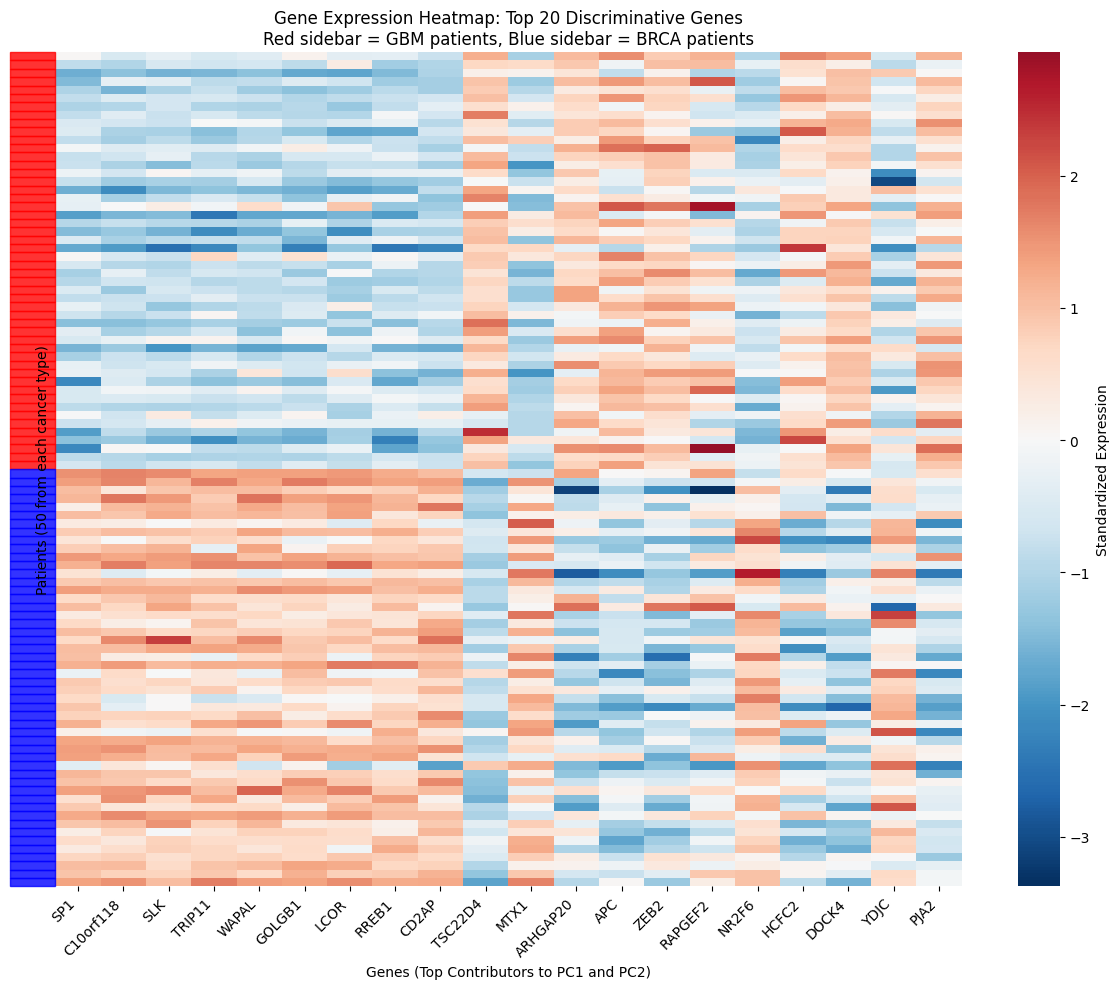

This heatmap shows the expression patterns of the most discriminative genes.
Notice how patients cluster by cancer type (red vs blue sidebar) based on these genes!


In [34]:
# Create heatmap focusing on the most informative genes
n_patients_each = 50  # Sample patients from each cancer type for cleaner visualization

# Get indices for random sample of each cancer type
np.random.seed(42)  # Reproducible sampling
gbm_indices = np.random.choice(np.where(tcga_type == "GBM")[0], n_patients_each, replace=False)
brca_indices = np.random.choice(np.where(tcga_type == "BRCA")[0], n_patients_each, replace=False)

# Combine patient indices
selected_patients = np.concatenate([gbm_indices, brca_indices])

# Get top genes from both PC1 and PC2
top_genes = pd.concat([pc1_top.head(10), pc2_top.head(10)])['gene'].tolist()

# Create subset of data with selected patients and top genes
heatmap_subset = tcga_sub_log.loc[selected_patients, top_genes]

# Standardize for better visualization
heatmap_standardized = (heatmap_subset - heatmap_subset.mean()) / heatmap_subset.std()

# Create annotation for cancer types
cancer_labels = [tcga_type.iloc[i] for i in selected_patients]
row_colors = ['red' if cancer == 'GBM' else 'blue' for cancer in cancer_labels]

# Create the enhanced heatmap
plt.figure(figsize=(12, 10))

# Create heatmap with hierarchical clustering disabled to maintain order
sns.heatmap(heatmap_standardized,
           cmap='RdBu_r',           # Red-Blue colormap (red=high, blue=low)
           center=0,               # Center colormap at 0
           cbar=True,
           xticklabels=True,       # Show gene names
           yticklabels=False,      # Hide patient IDs (too many)
           cbar_kws={'label': 'Standardized Expression'})

# Add color bar for cancer types
for i, color in enumerate(row_colors):
    plt.axhspan(i, i+1, xmin=-0.05, xmax=0, color=color, alpha=0.8, clip_on=False)

plt.title(f'Gene Expression Heatmap: Top {len(top_genes)} Discriminative Genes\n' +
          f'Red sidebar = GBM patients, Blue sidebar = BRCA patients', fontsize=12)
plt.xlabel('Genes (Top Contributors to PC1 and PC2)')
plt.ylabel(f'Patients ({n_patients_each} from each cancer type)')

# Rotate gene names for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("This heatmap shows the expression patterns of the most discriminative genes.")
print("Notice how patients cluster by cancer type (red vs blue sidebar) based on these genes!")

This is indeed a beautiful and scientifically meaningful visualization! The heatmap shows the expression patterns of the genes that contribute most to separating the cancer types. Each row represents a patient (with cancer type indicated by the colored sidebar), and each column represents one of the most discriminative genes. The clear visual separation between the two cancer types demonstrates that these top-loading genes systematically capture the biological differences between breast and brain cancers. The red-blue color scheme shows which genes are over-expressed (red) or under-expressed (blue) in each cancer type. This type of analysis can guide researchers toward potential biomarkers and therapeutic targets.

Now what if we take the smallest loadings in terms of absolute value? We can't really differentiate between two groups.

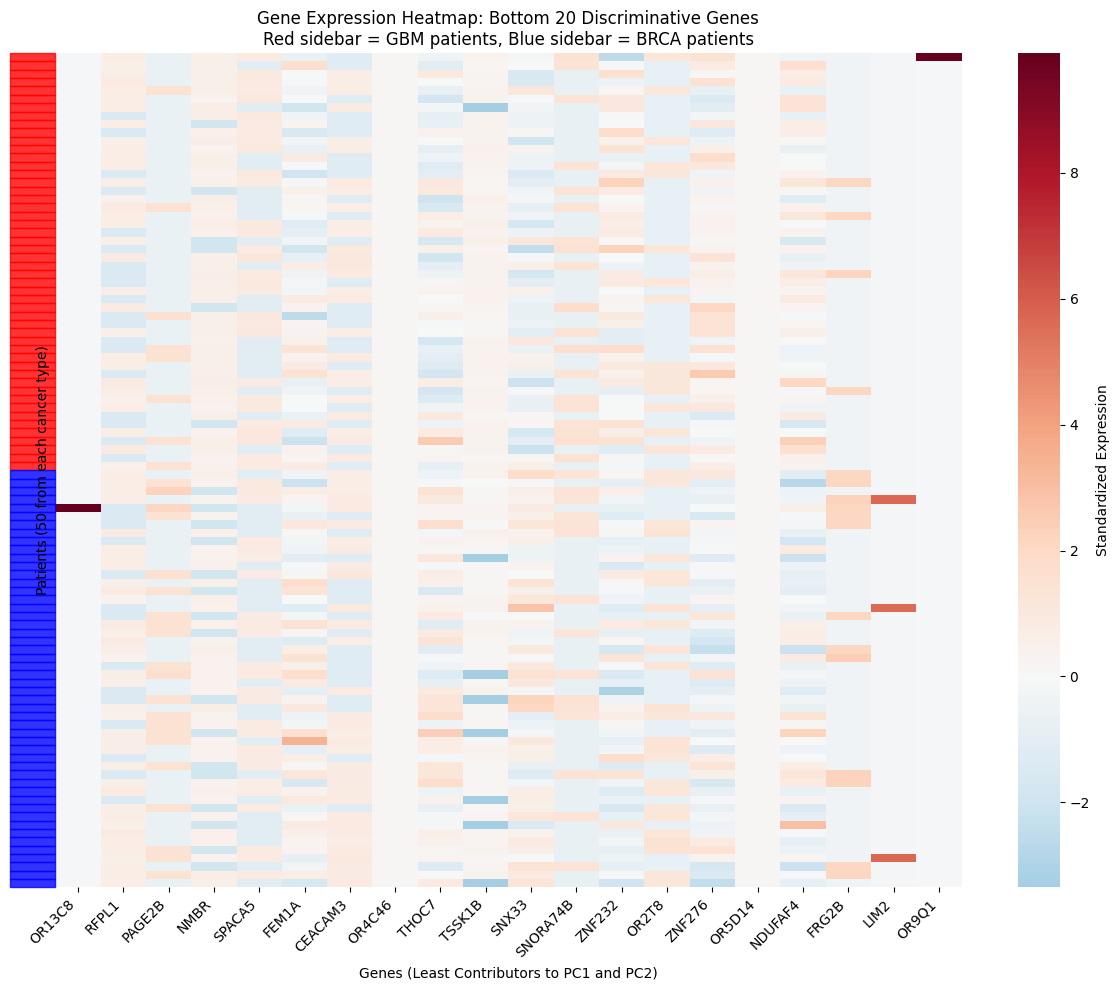

Notice how this heatmap shows much less clear separation between cancer types!
Genes with low PC loadings don't systematically differ between cancer types.

Top genes - average absolute loading: 0.0193
Bottom genes - average absolute loading: 0.0000


In [35]:
# Analyze genes with the smallest loadings (least discriminative)
bottom_k = 20  # Number of bottom genes to examine

# Find genes with smallest absolute loadings for PC1 and PC2
pc1_bottom = pc1_loadings.reindex(pc1_loadings['loading'].abs().sort_values(ascending=True).index).head(bottom_k)
pc2_bottom = pc2_loadings.reindex(pc2_loadings['loading'].abs().sort_values(ascending=True).index).head(bottom_k)

# Get bottom genes from both PCs
bottom_genes = pd.concat([pc1_bottom.head(10), pc2_bottom.head(10)])['gene'].tolist()

# Create heatmap subset with least discriminative genes
heatmap_bottom = tcga_sub_log.loc[selected_patients, bottom_genes]
heatmap_bottom_std = (heatmap_bottom - heatmap_bottom.mean()) / heatmap_bottom.std()

# Create comparison heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(heatmap_bottom_std,
           cmap='RdBu_r',
           center=0,
           cbar=True,
           xticklabels=True,
           yticklabels=False,
           cbar_kws={'label': 'Standardized Expression'})

# Add cancer type color bar
for i, color in enumerate(row_colors):
    plt.axhspan(i, i+1, xmin=-0.05, xmax=0, color=color, alpha=0.8, clip_on=False)

plt.title(f'Gene Expression Heatmap: Bottom {len(bottom_genes)} Discriminative Genes\n' +
          f'Red sidebar = GBM patients, Blue sidebar = BRCA patients', fontsize=12)
plt.xlabel('Genes (Least Contributors to PC1 and PC2)')
plt.ylabel(f'Patients ({n_patients_each} from each cancer type)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Notice how this heatmap shows much less clear separation between cancer types!")
print("Genes with low PC loadings don't systematically differ between cancer types.")

# Show the contrast in loading magnitudes
print(f"\nTop genes - average absolute loading: {np.mean([abs(x) for x in pd.concat([pc1_top.head(10), pc2_top.head(10)])['loading']]):.4f}")
print(f"Bottom genes - average absolute loading: {np.mean([abs(x) for x in pd.concat([pc1_bottom.head(10), pc2_bottom.head(10)])['loading']]):.4f}")

This contrasting heatmap demonstrates why Principal Component Analysis is so powerful for identifying biologically meaningful patterns. Unlike the previous heatmap with high-loading genes that showed clear separation between cancer types, this heatmap using low-loading genes shows no systematic patterns. The patients don't cluster by cancer type when we focus on genes that contribute little to the principal components. This validates our PCA approach - it successfully identified the genes that matter most for distinguishing cancer types while filtering out genes that show random or uninformative variation. The dramatic difference in average loading magnitudes quantifies this contrast.

**Question:**

What if we do not scale when PCA?

## SVD with TruncatedSVD()

Since we only need leading PCs, we only need to calculate the leading PCs. We use `TruncatedSVD()` to approximate the leading few singular values with their corresponding singular vectors. Watch how fast the spectrum analysis can be done, instantly!!!!

Performing fast SVD approximation...
TruncatedSVD completed in 2.77 seconds
Speed comparison with full PCA:
TruncatedSVD: Focus on just the most important patterns
Full PCA: Computes all components then discards most


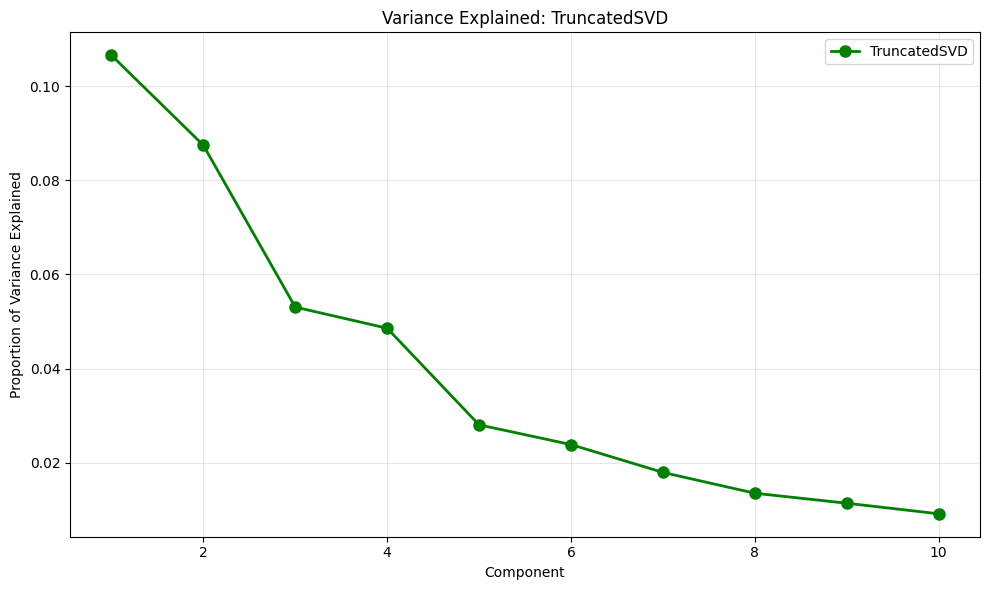

First 3 components explain 0.2471 (24.71%) of variance


In [36]:
# Use TruncatedSVD for fast approximate computation of leading PCs
print("Performing fast SVD approximation...")
start_time = time.time()

# Center and scale the data manually for SVD
tcga_centered_scaled = StandardScaler().fit_transform(tcga_sub_log)

# Use TruncatedSVD to compute only the first 10 components
svd = TruncatedSVD(n_components=10, random_state=42)  # Only compute top 10 components
tcga_svd_scores = svd.fit_transform(tcga_centered_scaled)

end_time = time.time()
print(f"TruncatedSVD completed in {end_time - start_time:.2f} seconds")

# Compare with PCA timing (TruncatedSVD should be much faster!)
print("Speed comparison with full PCA:")
print("TruncatedSVD: Focus on just the most important patterns")
print("Full PCA: Computes all components then discards most")

# Approximate the Proportion of Variance Explained
# For SVD: explained variance = singular_values^2 / (n_samples - 1)
svd_variance = svd.singular_values_**2 / (len(tcga_centered_scaled) - 1)
total_variance = np.sum(np.var(tcga_centered_scaled, axis=0))  # Total variance in original data
pve_svd = svd_variance / total_variance  # Proportion explained by each component

# Plot comparison of variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pve_svd, 'go-', linewidth=2, markersize=8, label='TruncatedSVD')
plt.xlabel('Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Variance Explained: TruncatedSVD')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"First 3 components explain {pve_svd[:3].sum():.4f} ({pve_svd[:3].sum()*100:.2f}%) of variance")

TruncatedSVD provides a computationally efficient alternative to full PCA when we only need the first few components. Instead of computing all ~20,000 components and then discarding most of them, TruncatedSVD directly computes only the components we need. This makes it much faster for high-dimensional data. The mathematical relationship between singular values and explained variance lets us still calculate how much variation each component explains. This approach is particularly valuable for very large datasets where full PCA might be prohibitively slow or use too much memory.

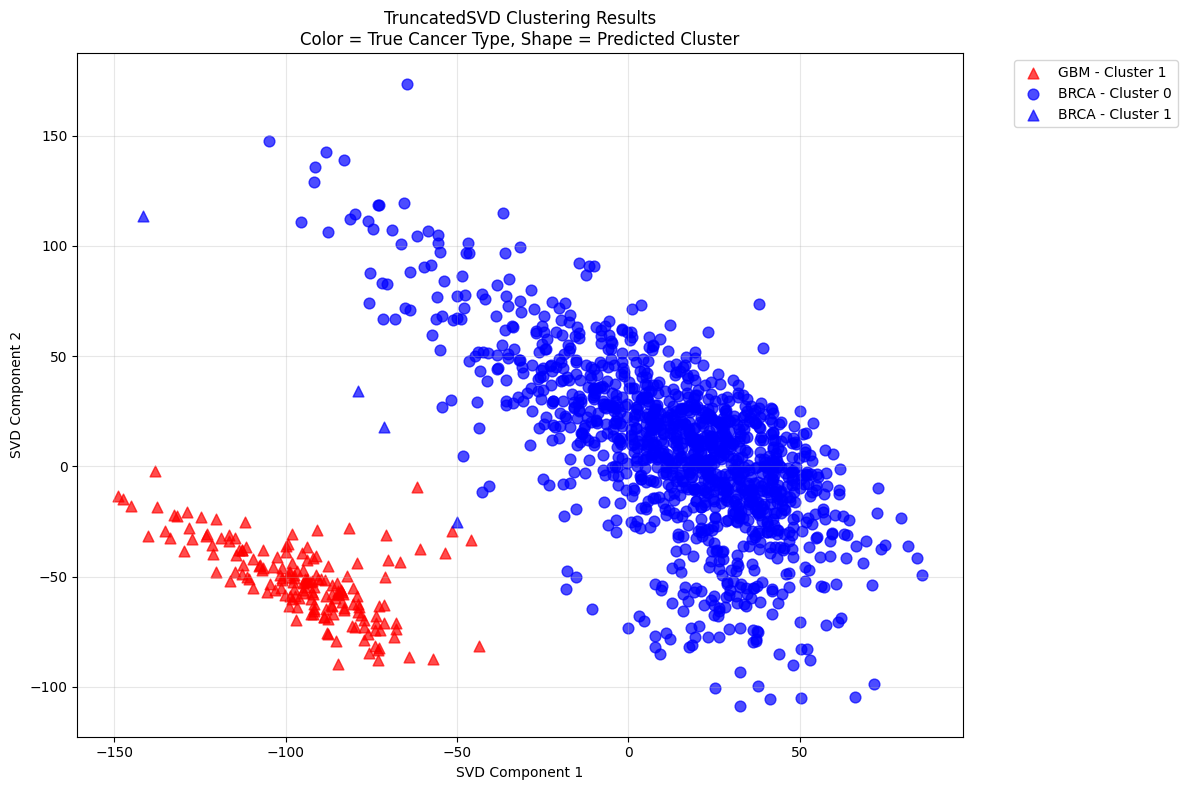

Final Accuracy Comparison:
Full clustering (~20K genes): 0.999
PCA clustering (3 PCs):       0.997
SVD clustering (3 components): 0.997

All methods achieve similar accuracy, demonstrating that dimension reduction preserves the essential information!


In [37]:
# Perform clustering using SVD-derived components
kmeans_svd = KMeans(n_clusters=2, random_state=42)
svd_cluster_labels = kmeans_svd.fit_predict(tcga_svd_scores[:, :3])  # Use first 3 SVD components

# Create final comparison visualization
plt.figure(figsize=(12, 8))

# Plot SVD-based clustering results colored by true cancer type
cancer_colors = {'GBM': 'red', 'BRCA': 'blue'}
cluster_shapes = {0: 'o', 1: '^'}

for cancer_type in ['GBM', 'BRCA']:
    for cluster_id in [0, 1]:
        mask = (tcga_type == cancer_type) & (svd_cluster_labels == cluster_id)

        if mask.any():
            plt.scatter(tcga_svd_scores[mask, 0],     # First SVD component
                       tcga_svd_scores[mask, 1],     # Second SVD component
                       c=cancer_colors[cancer_type],
                       marker=cluster_shapes[cluster_id],
                       s=60, alpha=0.7,
                       label=f'{cancer_type} - Cluster {cluster_id}')

plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('TruncatedSVD Clustering Results\nColor = True Cancer Type, Shape = Predicted Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate SVD clustering accuracy
svd_accuracy1 = sum((tcga_type == 'BRCA') == (svd_cluster_labels == 0)) / len(tcga_type)
svd_accuracy2 = sum((tcga_type == 'BRCA') == (svd_cluster_labels == 1)) / len(tcga_type)
svd_best_accuracy = max(svd_accuracy1, svd_accuracy2)

# Final comparison of all methods
print("Final Accuracy Comparison:")
print(f"Full clustering (~20K genes): {full_accuracy:.3f}")
print(f"PCA clustering (3 PCs):       {pca_best_accuracy:.3f}")
print(f"SVD clustering (3 components): {svd_best_accuracy:.3f}")
print("\nAll methods achieve similar accuracy, demonstrating that dimension reduction preserves the essential information!")

This final comparison shows that all three approaches - full-dimensional clustering, PCA-based clustering, and TruncatedSVD clustering - achieve remarkably similar accuracy. This is a powerful demonstration of the effectiveness of dimensionality reduction: we can reduce from nearly 20,000 dimensions to just 3 while preserving virtually all the information needed to distinguish between cancer types. The computational savings are enormous while the biological insights remain intact. This principle applies broadly in genomics and other high-dimensional fields where dimensionality reduction techniques can make complex analyses both feasible and interpretable.

## Appendix 1: Silhouette Method

Keep this section as a reference for now.

Silhouette coefficient is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

**Formula:** s = (b - a) / max(a,b)

where:
- s is the silhouette coefficient of the data point
- a is the average distance between and all the other data points in the cluster to which the data point belongs  
- b is the minimum average distance from the data point to all clusters to which the data point does not belong

The value of the silhouette coefficient is between [-1, 1].
- The higher means the point is better fit to the cluster group.
- 0 means overlapping between clusters.

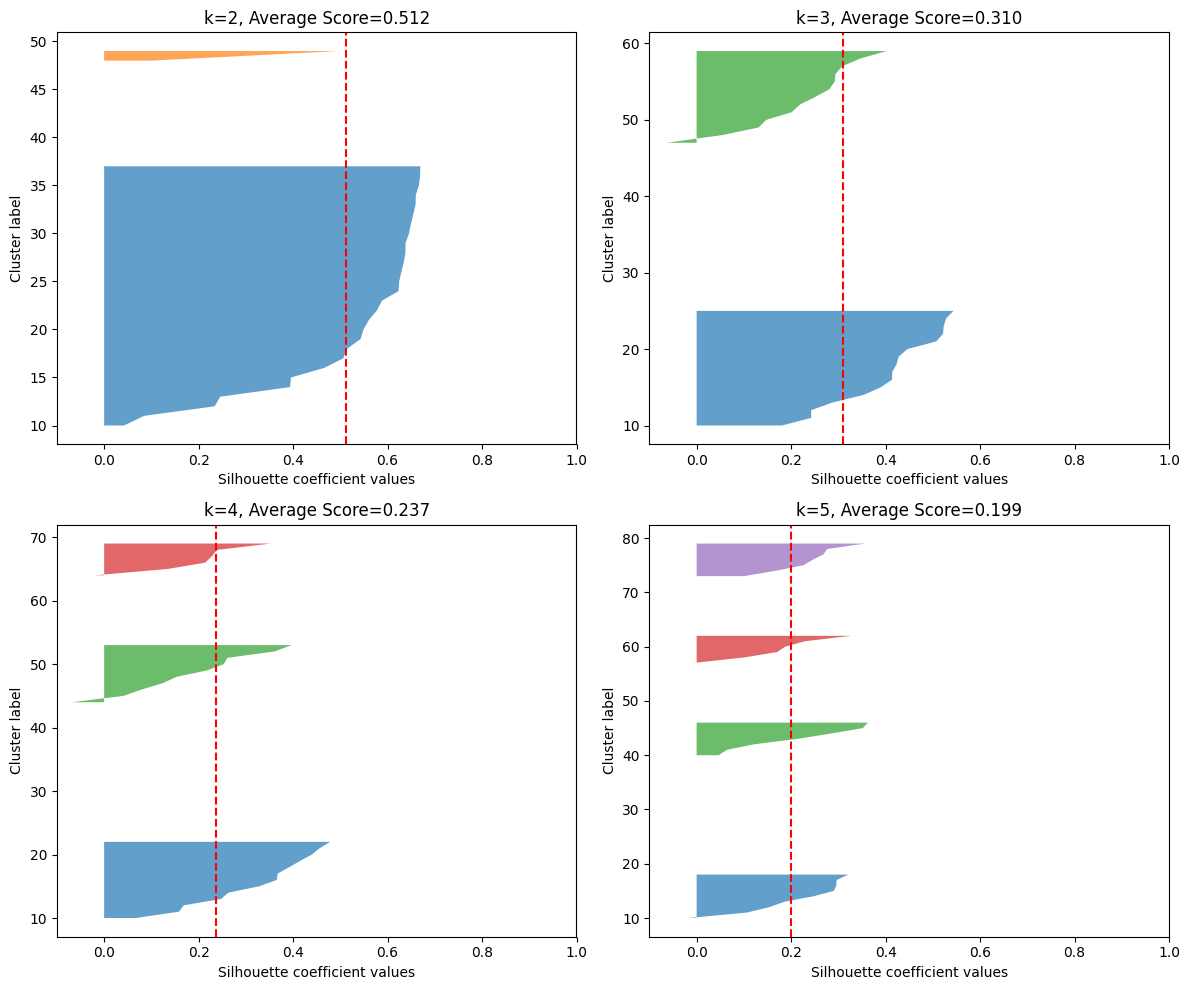

In [38]:
# Demonstrate silhouette analysis for the baseball data
from sklearn.metrics import silhouette_score, silhouette_samples

# Calculate silhouette scores for different numbers of clusters
k_range = range(2, 6)  # Test k=2,3,4,5
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of plots
axes = axes.ravel()

for i, k in enumerate(k_range):
    # Perform clustering for k clusters
    kmeans_k = KMeans(n_clusters=k, random_state=42)
    cluster_labels_k = kmeans_k.fit_predict(payroll_data)

    # Calculate silhouette scores for each sample
    silhouette_avg = silhouette_score(payroll_data, cluster_labels_k)
    sample_silhouette_values = silhouette_samples(payroll_data, cluster_labels_k)

    # Create silhouette plot
    ax = axes[i]
    y_lower = 10

    for cluster_id in range(k):
        # Get silhouette values for samples in this cluster
        cluster_silhouette_values = sample_silhouette_values[cluster_labels_k == cluster_id]
        cluster_silhouette_values.sort()

        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        # Fill area for this cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, cluster_silhouette_values,
                        alpha=0.7, label=f'Cluster {cluster_id}')

        y_lower = y_upper + 10  # Add gap between clusters

    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_title(f'k={k}, Average Score={silhouette_avg:.3f}')

    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

Silhouette analysis provides another method for determining optimal cluster numbers and evaluating cluster quality. Each bar in these plots represents one data point, with the width showing its silhouette coefficient. Wider bars mean the point fits well in its assigned cluster and is far from other clusters. The red dashed line shows the average silhouette score - higher averages suggest better clustering. Clusters with many negative silhouette values indicate points that might be in the wrong cluster. This analysis complements the elbow method by focusing on how well-separated and internally cohesive the clusters are.

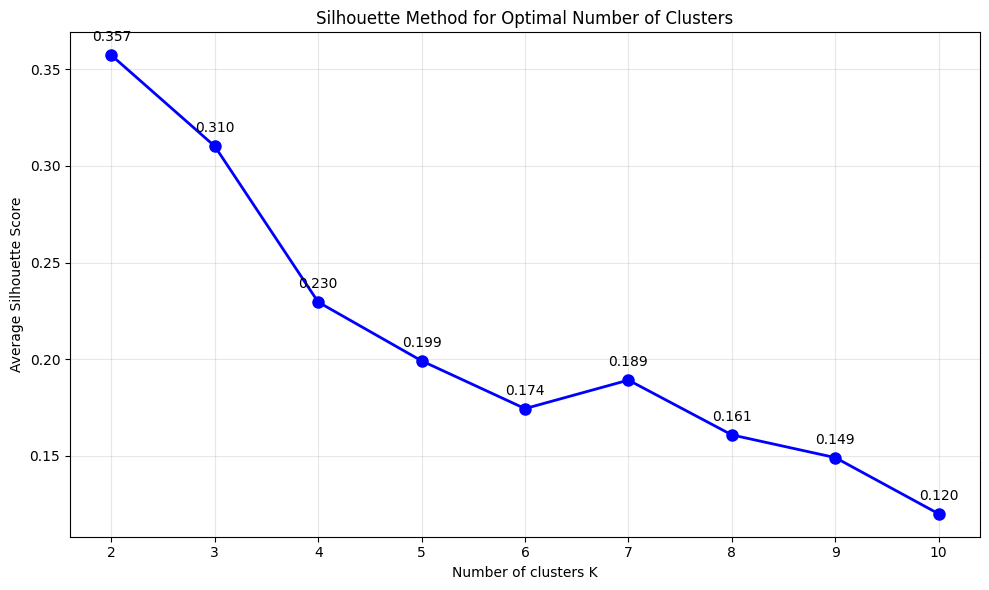

Optimal number of clusters according to silhouette method: 2
Best average silhouette score: 0.357


In [39]:
# Calculate average silhouette scores for different k values
def calculate_avg_silhouette(data, k_range):
    """Calculate average silhouette score for different k values"""
    avg_scores = []

    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans_temp.fit_predict(data)
        avg_score = silhouette_score(data, cluster_labels)
        avg_scores.append(avg_score)

    return avg_scores

# Test silhouette method on baseball data
k_values = range(2, 11)
avg_silhouette_scores = calculate_avg_silhouette(payroll_data, k_values)

# Plot average silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters K')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)

# Add value annotations
for k, score in zip(k_values, avg_silhouette_scores):
    plt.annotate(f'{score:.3f}', (k, score),
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

optimal_k = k_values[np.argmax(avg_silhouette_scores)]
print(f"Optimal number of clusters according to silhouette method: {optimal_k}")
print(f"Best average silhouette score: {max(avg_silhouette_scores):.3f}")

This final silhouette analysis summarizes the optimal cluster numbers by finding the k value that maximizes the average silhouette score. Unlike the elbow method which looks for diminishing returns, the silhouette method directly measures cluster quality. The optimal k is the one that produces the highest average silhouette score, indicating the best balance between cluster cohesion (points close to their cluster center) and cluster separation (clusters far from each other). Both methods together provide robust guidance for choosing the number of clusters in unsupervised learning problems.